# Iris Data Generation

# Index

1. [Libraries](#Libraries)
2. [Data Preparation](#Getting-Started)
3. [Exploring Architectures](#GAN-vs-VAE)
3. [Generating Syntethic Data](#Conditional-Generative-Adversarial-Network)
4. [Syntethic VS Real](#Quality-assessment)
5. [Conclusion](#Conclusion)

## Libraries

In [1]:
import sys
import os

import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import skew, kurtosis, iqr, entropy

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchmetrics

import random
from tqdm.auto import tqdm

Seed function for reproducibility.

In [2]:
def set_seed(seed = 0):
    
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [3]:
project_path = os.path.abspath("..")

if project_path not in sys.path:
    sys.path.append(project_path)

import utils

## Getting Started
The iris dataset will be used to validate the tabular data generation protocol, which despite its apparent simplicity may harbor pitfalls.

In [4]:
X, y = load_iris()['data'], load_iris()['target']
features, species = load_iris()['feature_names'], load_iris()['target_names']

real_iris = pd.DataFrame(X, columns = features)
real_iris['target'] = y
real_iris['target'] = real_iris['target'].map({i: species[i] for i in range(len(species))})
real_iris.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


Let's deep dive into our real data.

In [5]:
utils.describe_data(real_iris, 'target')

REAL                     
                       setosa versicolor virginica
MEAN sepal length (cm)  5.006      5.936     6.588
     sepal width (cm)   3.428      2.770     2.974
     petal length (cm)  1.462      4.260     5.552
     petal width (cm)   0.246      1.326     2.026
STD  sepal length (cm)  0.352      0.516     0.636
     sepal width (cm)   0.379      0.314     0.322
     petal length (cm)  0.174      0.470     0.552
     petal width (cm)   0.105      0.198     0.275
MIN  sepal length (cm)  4.300      4.900     4.900
     sepal width (cm)   2.300      2.000     2.200
     petal length (cm)  1.000      3.000     4.500
     petal width (cm)   0.100      1.000     1.400
MAX  sepal length (cm)  5.800      7.000     7.900
     sepal width (cm)   4.400      3.400     3.800
     petal length (cm)  1.900      5.100     6.900
     petal width (cm)   0.600      1.800     2.500
SKEW sepal length (cm)  0.116      0.102     0.114
     sepal width (cm)   0.040     -0.352     0.355
     petal length (cm)  0.103     -0.588     0.533
     petal width (cm)   1.216     -0.030    -0.126
KURT sepal length (cm) -0.346     -0.599    -0.088
     sepal width (cm)   0.744     -0.448     0.520
     petal length (cm)  0.805     -0.074    -0.256
     petal width (cm)   1.434     -0.488    -0.661
IQR  sepal length (cm)  0.400      0.700     0.675
     sepal width (cm)   0.475      0.475     0.375
     petal length (cm)  0.175      0.600     0.775
     petal width (cm)   0.100      0.300     0.500

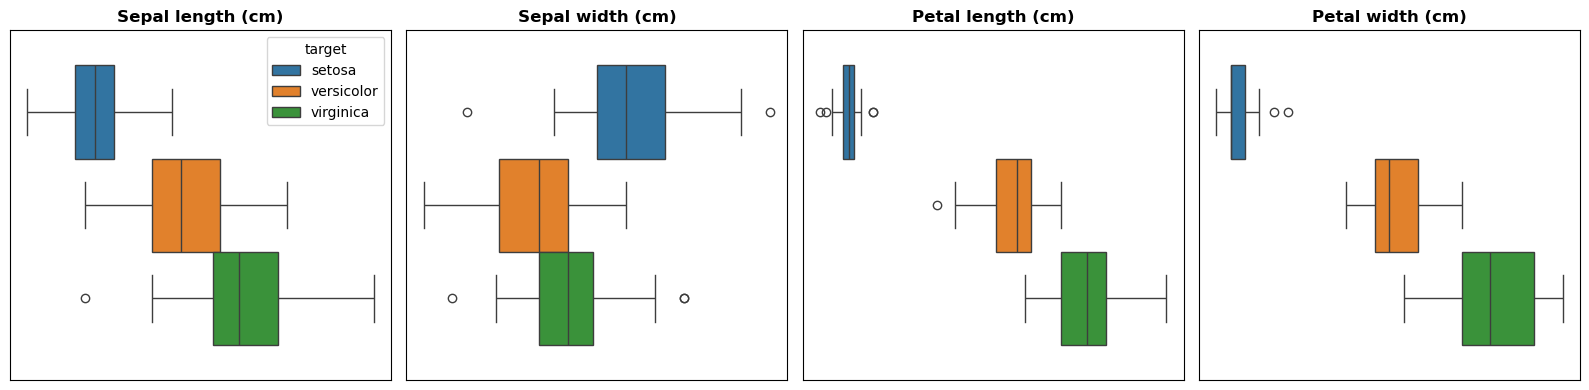

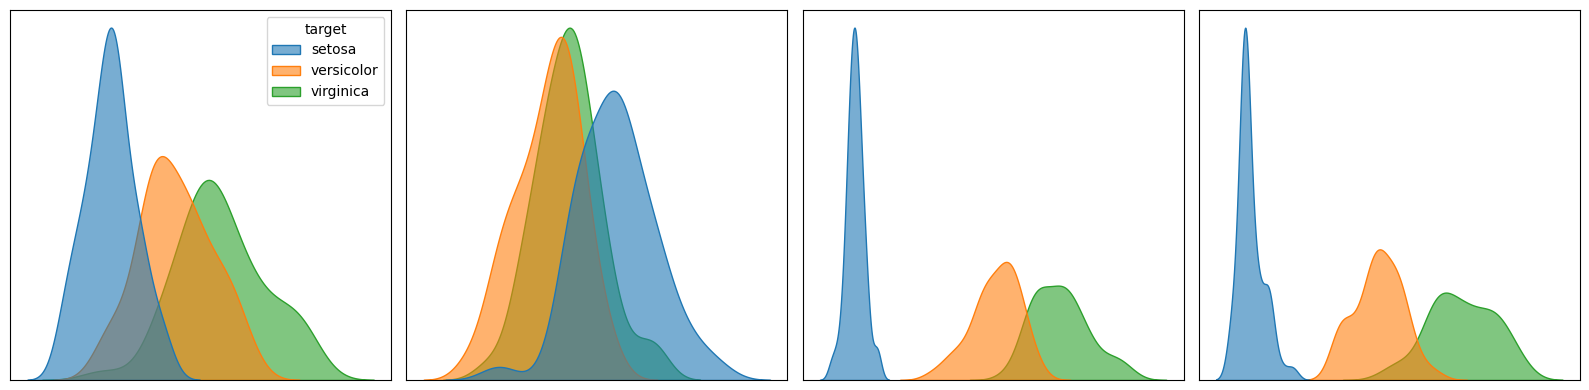

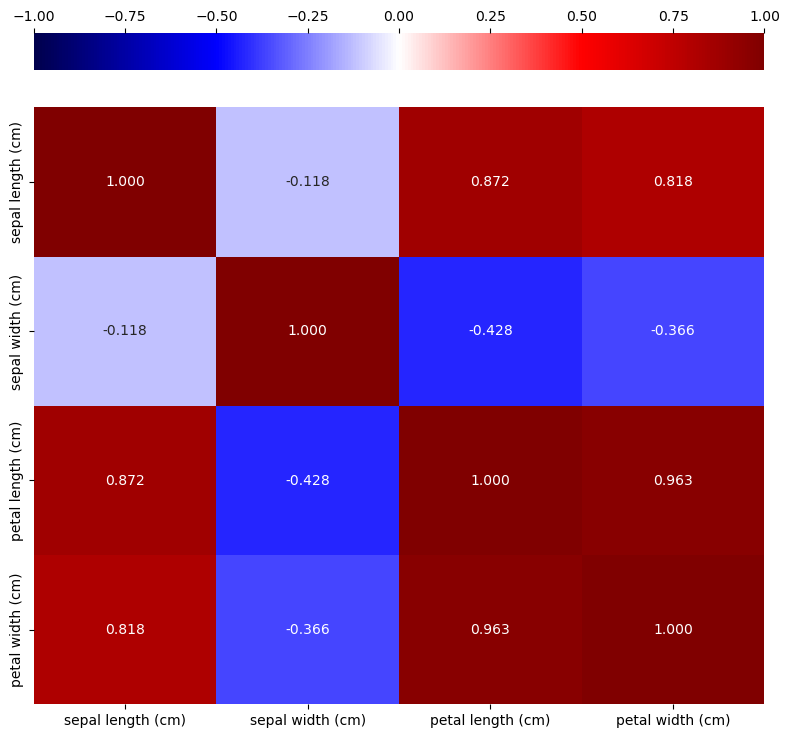

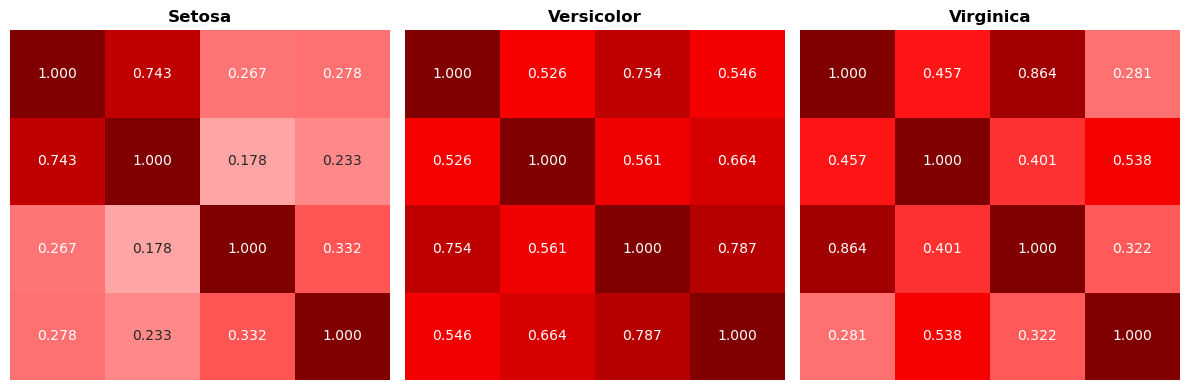

In [6]:
utils.plot_data(real_iris, 'target')

Throughout the notebook we will make comparisons between two datasets, one real and one synthetic; the following dataset, generated by adding normal noise to the real one, is used to introduce the comparison functions.

In [7]:
df = real_iris.select_dtypes('number') + np.random.normal(0, 1, (150,4))
df['target'] = real_iris['target']
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.279350,2.858060,1.868421,1.682761,setosa
1,4.804868,3.901714,0.653986,1.166979,setosa
2,5.169611,4.034741,1.588584,-1.485574,setosa
3,4.445050,4.466539,4.134708,-0.117932,setosa
4,6.057828,2.892329,1.999966,-0.784547,setosa


Let's start with comparisons! 

First of all a simply comparison between descriptives.

In [8]:
utils.describe_data(real_iris, 'target', df)

REAL                      SYNTHETIC             \
                       setosa versicolor virginica    setosa versicolor   
MEAN sepal length (cm)  5.006      5.936     6.588     5.069      5.833   
     sepal width (cm)   3.428      2.770     2.974     3.482      2.906   
     petal length (cm)  1.462      4.260     5.552     1.565      4.369   
     petal width (cm)   0.246      1.326     2.026     0.388      1.049   
STD  sepal length (cm)  0.352      0.516     0.636     1.016      0.932   
     sepal width (cm)   0.379      0.314     0.322     0.959      0.948   
     petal length (cm)  0.174      0.470     0.552     1.213      1.047   
     petal width (cm)   0.105      0.198     0.275     0.914      1.081   
MIN  sepal length (cm)  4.300      4.900     4.900     2.608      3.785   
     sepal width (cm)   2.300      2.000     2.200     1.254      1.264   
     petal length (cm)  1.000      3.000     4.500    -1.166      2.533   
     petal width (cm)   0.100      1.000     1.400    -1.527     -1.593   
MAX  sepal length (cm)  5.800      7.000     7.900     7.270      8.128   
     sepal width (cm)   4.400      3.400     3.800     5.981      4.584   
     petal length (cm)  1.900      5.100     6.900     4.185      7.126   
     petal width (cm)   0.600      1.800     2.500     1.961      3.131   
SKEW sepal length (cm)  0.116      0.102     0.114     0.172     -0.188   
     sepal width (cm)   0.040     -0.352     0.355     0.239      0.141   
     petal length (cm)  0.103     -0.588     0.533     0.009      0.476   
     petal width (cm)   1.216     -0.030    -0.126    -0.192     -0.174   
KURT sepal length (cm) -0.346     -0.599    -0.088     0.013     -0.427   
     sepal width (cm)   0.744     -0.448     0.520    -0.069     -1.033   
     petal length (cm)  0.805     -0.074    -0.256    -0.059     -0.201   
     petal width (cm)   1.434     -0.488    -0.661    -0.849     -0.752   
IQR  sepal length (cm)  0.400      0.700     0.675     1.287      1.367   
     sepal width (cm)   0.475      0.475     0.375     1.240      1.489   
     petal length (cm)  0.175      0.600     0.775     1.311      1.163   
     petal width (cm)   0.100      0.300     0.500     1.434      1.761   

                                  
                       virginica  
MEAN sepal length (cm)     6.622  
     sepal width (cm)      3.025  
     petal length (cm)     5.432  
     petal width (cm)      2.267  
STD  sepal length (cm)     1.313  
     sepal width (cm)      1.056  
     petal length (cm)     0.986  
     petal width (cm)      0.962  
MIN  sepal length (cm)     3.602  
     sepal width (cm)      0.798  
     petal length (cm)     3.426  
     petal width (cm)      0.122  
MAX  sepal length (cm)     8.953  
     sepal width (cm)      5.959  
     petal length (cm)     7.644  
     petal width (cm)      4.067  
SKEW sepal length (cm)    -0.260  
     sepal width (cm)      0.443  
     petal length (cm)     0.082  
     petal width (cm)     -0.097  
KURT sepal length (cm)    -0.331  
     sepal width (cm)      0.354  
     petal length (cm)    -0.412  
     petal width (cm)     -0.638  
IQR  sepal length (cm)     1.849  
     sepal width (cm)      1.297  
     petal length (cm)     1.308  
     petal width (cm)      1.168

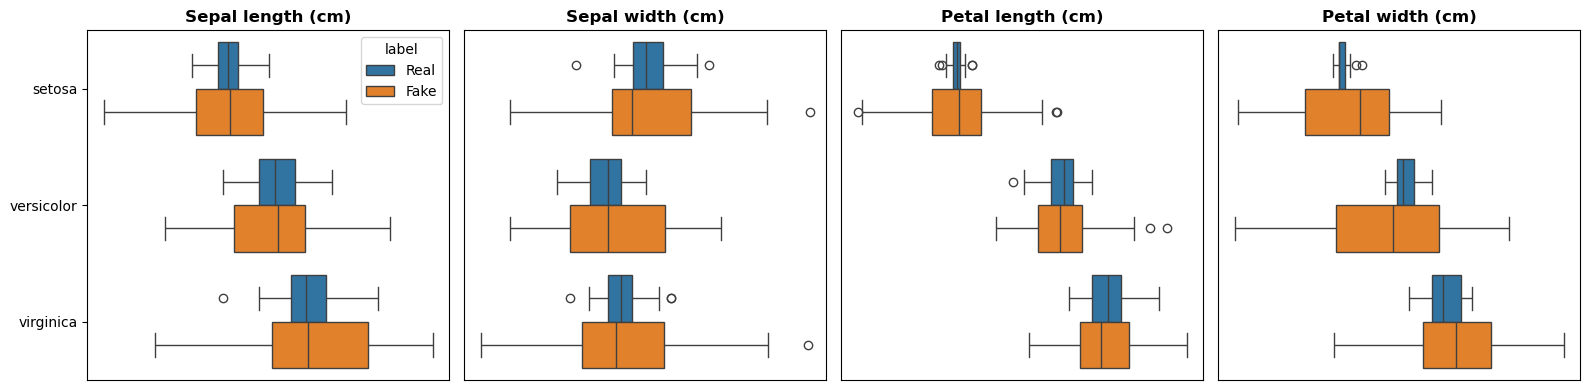

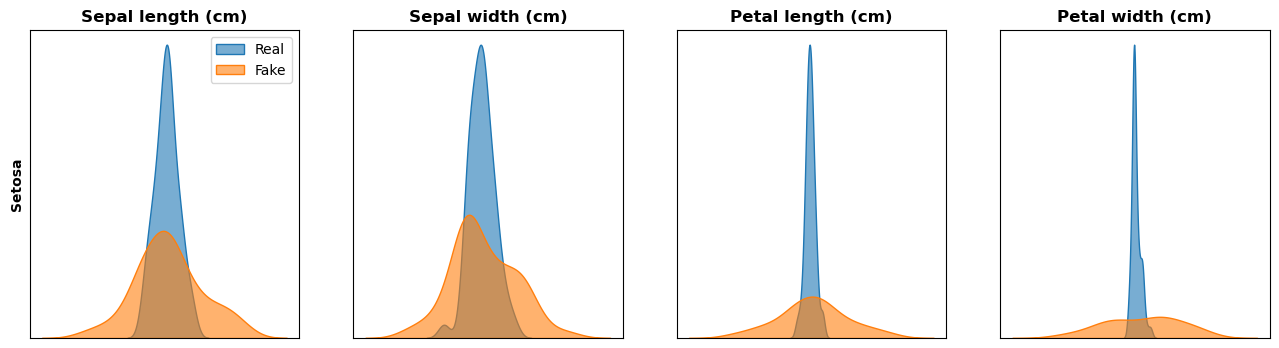

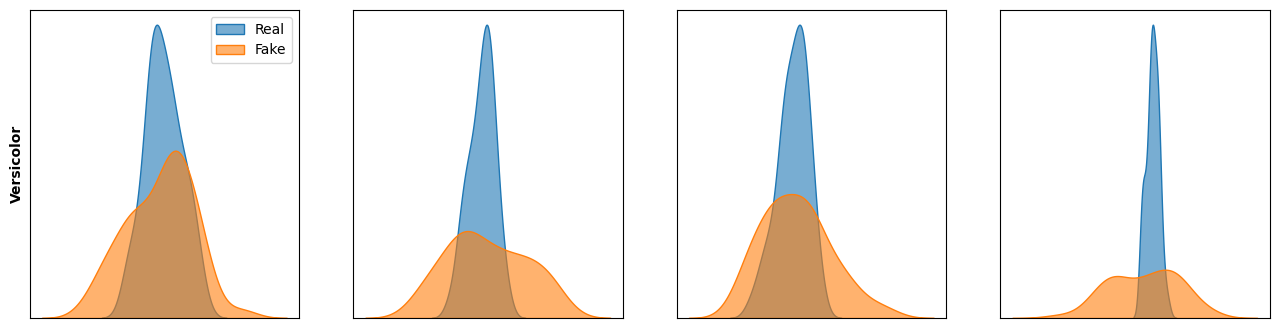

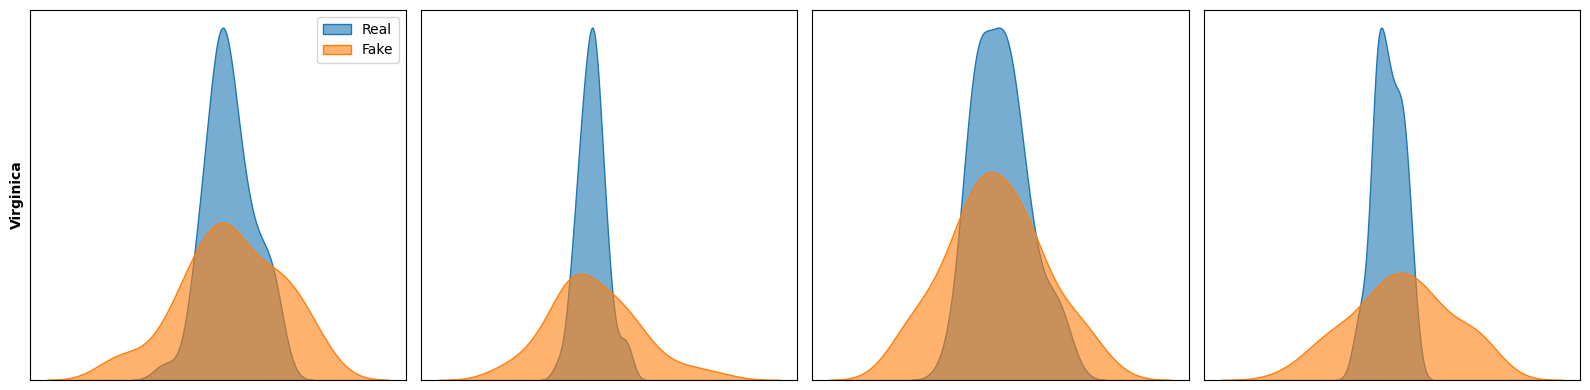

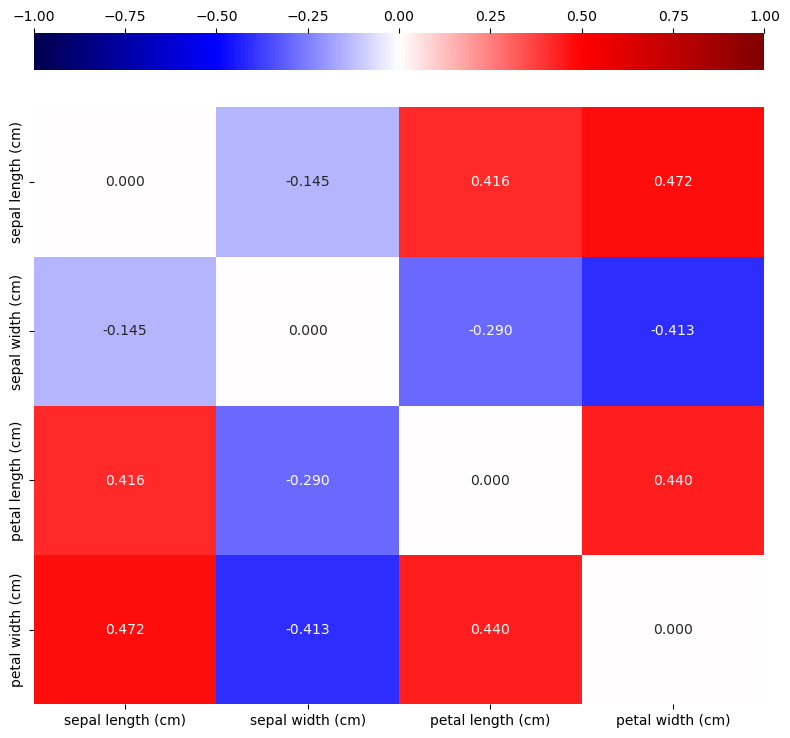

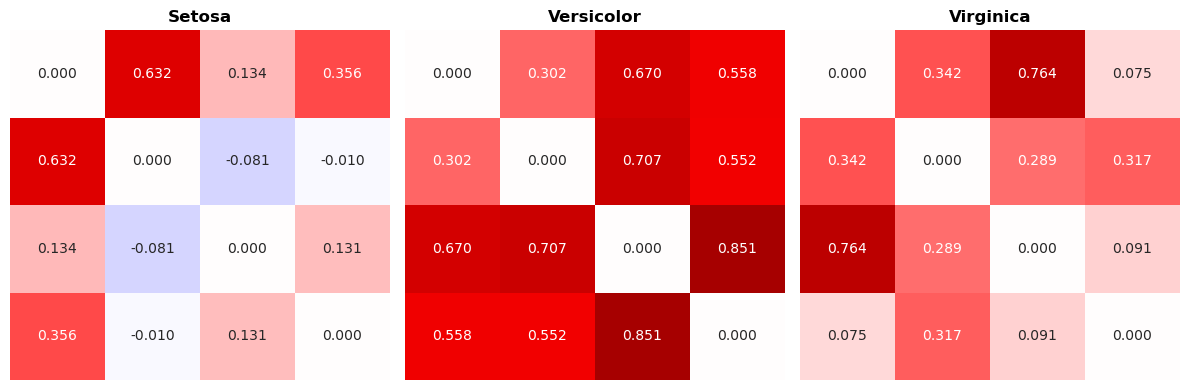

In [9]:
utils.plot_data(real_iris, 'target', df)

Throughout the work, the goal will be to minimize the differences, numerical and graphical, between the actual and synthetic data. Two different architectures will be used to achieve this goal: the Variational Auto Encoder **(VAE)** and the Generative Adversarial Network **(GAN)**, and the one that will show the best performance for the same task complexity and resources will be selected.

## GAN vs VAE

Both valid, the two approaches show different challenges and advantages:

1. **Variational Auto Encoder**:

Pros:
- Easy to train
- We can look inside the neaural network "Black Box"

Cons:

- Less coverage of variability
- Assumption of data normality

2. **Generative Adversarial Network**:

Pros:
- More realistic generated data
- Flexibility with respect to actual data distributions

Cons:
- Hard to train (model collapse, lot of resources, lot of data)
- Lower interpretability

The performance of the two architectures will be analyzed using them in as simple a version as possible. The next step will then be to prepare the data for modeling.

In [10]:
std_scl = StandardScaler()
X_scld = std_scl.fit_transform(X)

ohe = OneHotEncoder(sparse_output = False)
y_ohe = ohe.fit_transform(y.reshape(-1,1))

Preparing Torch Dataset and Dataloader

In [11]:
class IrisDataset(Dataset):
    def __init__(self, data, target):
        self.data = torch.tensor(data, dtype = torch.float32)
        self.label = torch.tensor(target, dtype = torch.long)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.label[idx]
    
real_vae_dataset = IrisDataset(X_scld, y_ohe)
real_vae_dataloader = DataLoader(real_vae_dataset, batch_size = 32, shuffle = True)

real_gan_dataset = IrisDataset(X_scld, y)
real_gan_dataloader = DataLoader(real_gan_dataset, batch_size = 32, shuffle = True)

for dataloader in [real_vae_dataloader, real_gan_dataloader]:
    for batch in dataloader:
        print(f'Data shape: {batch[0].shape}, labels shape: {batch[1].shape}')
        break

Data shape: torch.Size([32, 4]), labels shape: torch.Size([32, 3])
Data shape: torch.Size([32, 4]), labels shape: torch.Size([32])


Let's build baseline models, starting with the Conditional VAE

In [12]:
class ConditionalVAE(nn.Module):
    def __init__(self, input_dim, latent_dim, condition_dim):
        super(ConditionalVAE, self).__init__()
        self.latent_dim = latent_dim
        
        self.encoder = nn.Sequential(
            nn.Linear(input_dim + condition_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
        )
        
        self.fc_mu = nn.Linear(16, latent_dim)
        self.fc_logvar = nn.Linear(16, latent_dim)
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + condition_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, input_dim),
            nn.Tanh()
        )
        
    def encode(self, x, c):
        x_cond = torch.cat([x, c], dim=1)
        h = self.encoder(x_cond)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, c):
        z_cond = torch.cat([z, c], dim=1)
        return self.decoder(z_cond)

    def forward(self, x, c):
        mu, logvar = self.encode(x, c)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z, c)
        return recon_x, mu, logvar
    

vae = ConditionalVAE(input_dim = 4, latent_dim = 4, condition_dim = 3)

for batch in real_vae_dataloader:
    vae_batch = batch
    break
    
vae_out = vae(vae_batch[0], vae_batch[1])
for out in vae_out:
    print(f'Shape: {out.shape}')

Shape: torch.Size([32, 4])
Shape: torch.Size([32, 4])
Shape: torch.Size([32, 4])


Now let's build the GANs net.

In [13]:
class Generator(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        
        self.label_emb = nn.Embedding(num_classes, num_classes)
        
        self.model = nn.Sequential(
            nn.Linear(input_dim + num_classes, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 4),
        )
        
    def forward(self, x, labels):
        label_embeddings = self.label_emb(labels)
        x = torch.cat([x, label_embeddings], dim = 1)
        x = self.model(x)
        return x
    
class Discriminator(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
            
        self.label_emb = nn.Embedding(num_classes, num_classes)
        
        self.model = nn.Sequential(
            nn.Linear(input_dim + num_classes, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x, labels):
        label_embeddings = self.label_emb(labels)
        x = torch.cat([x, label_embeddings], dim = 1)
        x = self.model(x)
        return x

gen = Generator(input_dim = 4, num_classes = 3)
disc = Discriminator(input_dim = 4, num_classes = 3)

for batch in real_gan_dataloader:
    gan_batch = batch
    break
    
print(f'Generator output shape: {gen(torch.randn(32, 4), gan_batch[1]).shape}')
print(f'Discriminator output shape: {disc(gan_batch[0], gan_batch[1]).shape}')

Generator output shape: torch.Size([32, 4])
Discriminator output shape: torch.Size([32, 1])


Let's check models' size in parameters.

In [14]:
print(f'VAE has {sum(p.numel() for p in vae.parameters())} parameters')
print(f'Gen has {sum(p.numel() for p in gen.parameters())} parameters')
print(f'Disc has {sum(p.numel() for p in disc.parameters())} parameters')

VAE has 1724 parameters
Gen has 861 parameters
Disc has 714 parameters


We can now train the simpliest Conditional VAE.

In [15]:
vae_opt = torch.optim.Adam(vae.parameters(), lr = 1e-3)

def vae_loss(reconstructed, original, mu, logvar, beta=1.0):
    recon_loss = F.mse_loss(reconstructed, original, reduction='mean')
    
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    kl_div /= original.size(0)

    total_loss = recon_loss + beta * kl_div
    return total_loss, recon_loss, kl_div

set_seed()

z = torch.randn(150, 4)

In [16]:
for epoch in tqdm(range(1, 501), desc = 'Training VAE'):
    
    vae.train()
    epoch_loss = 0
    
    for data, label in real_vae_dataloader:
        
        reconstructed, mu, logvar = vae(data, label)
        loss, recon_loss, kl_div = vae_loss(reconstructed, data, mu, logvar)
        
        vae_opt.zero_grad()
        loss.backward()
        vae_opt.step()
        
        epoch_loss += loss.item()
        
    epoch_total_loss = epoch_loss/len(real_vae_dataloader)
    
    if epoch % 50 == 0 or epoch == 50:
        
        print(f'\nEpoch {epoch}/500 | Loss: {epoch_total_loss:.4f}')
        with torch.no_grad():
            vae.eval()
            vae_z = vae(z, real_vae_dataloader.dataset.label)[0]
            utils.compare_results(real_vae_dataloader.dataset.data, vae_z)

Training VAE:   0%|          | 0/500 [00:00<?, ?it/s]


Epoch 50/500 | Loss: 0.3182
MEAN: [-0.025 -0.001 -0.092 -0.067]
STD:  [0.307 0.435 0.245 0.259]
MIN:  [-0.926 -1.659 -0.597 -0.482]
MAX:  [1.632 2.216 0.839 0.772]
SKEW: [ 0.586 -0.277  0.104  0.213]
KURT: [0.926 1.631 0.11  0.168]

Epoch 100/500 | Loss: 0.3031
MEAN: [-0.019 -0.005 -0.09  -0.054]
STD:  [0.237 0.366 0.193 0.2  ]
MIN:  [-0.887 -1.656 -0.573 -0.454]
MAX:  [1.544 2.152 0.803 0.727]
SKEW: [ 0.488 -0.101  0.072  0.115]
KURT: [0.938 1.67  0.123 0.186]

Epoch 150/500 | Loss: 0.2968
MEAN: [-0.018  0.002 -0.096 -0.058]
STD:  [0.227 0.358 0.183 0.191]
MIN:  [-0.88 -1.71 -0.57 -0.45]
MAX:  [1.547 2.15  0.798 0.721]
SKEW: [ 0.504 -0.143  0.09   0.126]
KURT: [0.928 1.668 0.11  0.171]

Epoch 200/500 | Loss: 0.2888
MEAN: [-0.021 -0.01  -0.101 -0.065]
STD:  [0.222 0.36  0.179 0.185]
MIN:  [-0.877 -1.702 -0.569 -0.449]
MAX:  [1.549 2.153 0.796 0.718]
SKEW: [ 0.517 -0.096  0.1    0.144]
KURT: [0.929 1.677 0.11  0.17 ]

Epoch 250/500 | Loss: 0.2890
MEAN: [-0.011  0.016 -0.095 -0.058]
STD

In [17]:
vae_df = pd.DataFrame(std_scl.inverse_transform(vae_z.detach().numpy()))
vae_df['target'] = y
vae_df['target'] = vae_df['target'].map({i: species[i] for i in range(len(species))})
vae_df.columns = real_iris.columns

In [18]:
utils.describe_data(real_iris, 'target', vae_df)

REAL                       SYNTHETIC             \
                       setosa versicolor virginica     setosa versicolor   
MEAN sepal length (cm)  5.006      5.936     6.588   5.025000      5.945   
     sepal width (cm)   3.428      2.770     2.974   3.427000      2.764   
     petal length (cm)  1.462      4.260     5.552   2.001000      4.298   
     petal width (cm)   0.246      1.326     2.026   0.441000      1.349   
STD  sepal length (cm)  0.352      0.516     0.636   0.004000      0.017   
     sepal width (cm)   0.379      0.314     0.322   0.014000      0.014   
     petal length (cm)  0.174      0.470     0.552   0.002000      0.065   
     petal width (cm)   0.105      0.198     0.275   0.001000      0.038   
MIN  sepal length (cm)  4.300      4.900     4.900   5.021000      5.919   
     sepal width (cm)   2.300      2.000     2.200   3.361000      2.734   
     petal length (cm)  1.000      3.000     4.500   1.999000      4.151   
     petal width (cm)   0.100      1.000     1.400   0.440000      1.274   
MAX  sepal length (cm)  5.800      7.000     7.900   5.047000      6.012   
     sepal width (cm)   4.400      3.400     3.800   3.452000      2.794   
     petal length (cm)  1.900      5.100     6.900   2.012000      4.512   
     petal width (cm)   0.600      1.800     2.500   0.448000      1.477   
SKEW sepal length (cm)  0.116      0.102     0.114   3.620000      1.186   
     sepal width (cm)   0.040     -0.352     0.355  -2.111000      0.174   
     petal length (cm)  0.103     -0.588     0.533   4.091000      0.423   
     petal width (cm)   1.216     -0.030    -0.126   5.042000      0.773   
KURT sepal length (cm) -0.346     -0.599    -0.088  16.405001      3.387   
     sepal width (cm)   0.744     -0.448     0.520   8.314000     -0.328   
     petal length (cm)  0.805     -0.074    -0.256  19.514000      1.271   
     petal width (cm)   1.434     -0.488    -0.661  28.247999      1.266   
IQR  sepal length (cm)  0.400      0.700     0.675   0.002000      0.023   
     sepal width (cm)   0.475      0.475     0.375   0.013000      0.015   
     petal length (cm)  0.175      0.600     0.775   0.001000      0.072   
     petal width (cm)   0.100      0.300     0.500   0.000000      0.049   

                                  
                       virginica  
MEAN sepal length (cm)     6.598  
     sepal width (cm)      2.973  
     petal length (cm)     5.503  
     petal width (cm)      1.956  
STD  sepal length (cm)     0.021  
     sepal width (cm)      0.020  
     petal length (cm)     0.009  
     petal width (cm)      0.002  
MIN  sepal length (cm)     6.532  
     sepal width (cm)      2.910  
     petal length (cm)     5.468  
     petal width (cm)      1.946  
MAX  sepal length (cm)     6.632  
     sepal width (cm)      3.013  
     petal length (cm)     5.513  
     petal width (cm)      1.958  
SKEW sepal length (cm)    -1.158  
     sepal width (cm)     -0.703  
     petal length (cm)    -1.957  
     petal width (cm)     -2.224  
KURT sepal length (cm)     1.437  
     sepal width (cm)      0.736  
     petal length (cm)     4.265  
     petal width (cm)      5.789  
IQR  sepal length (cm)     0.019  
     sepal width (cm)      0.029  
     petal length (cm)     0.007  
     petal width (cm)      0.002

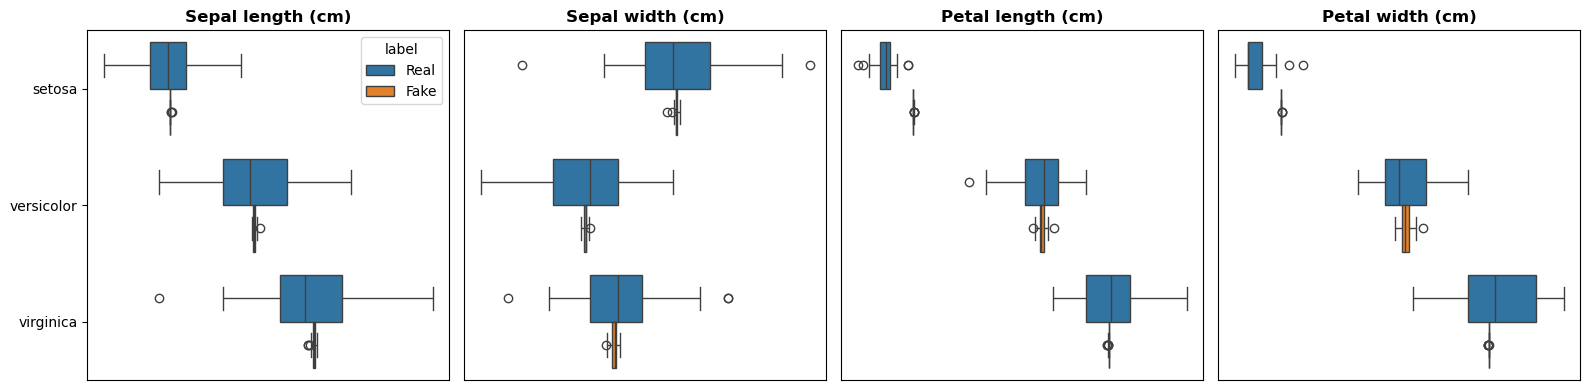

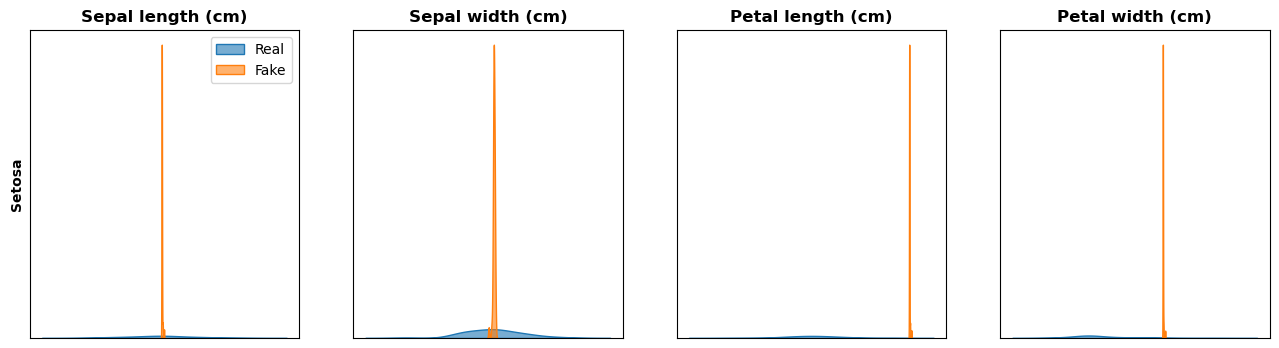

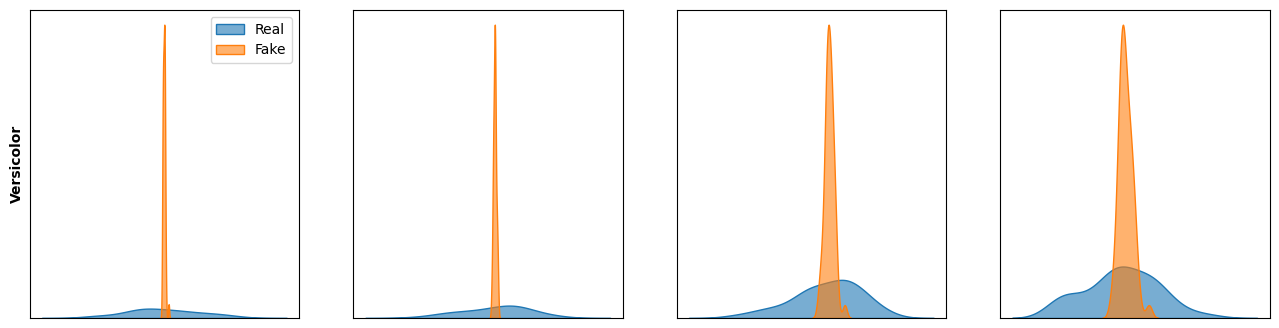

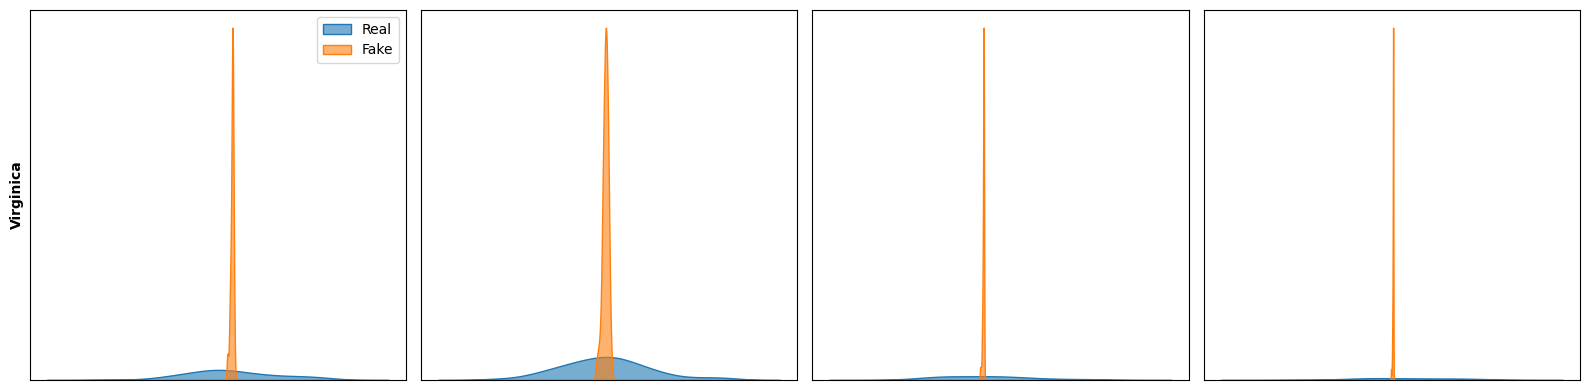

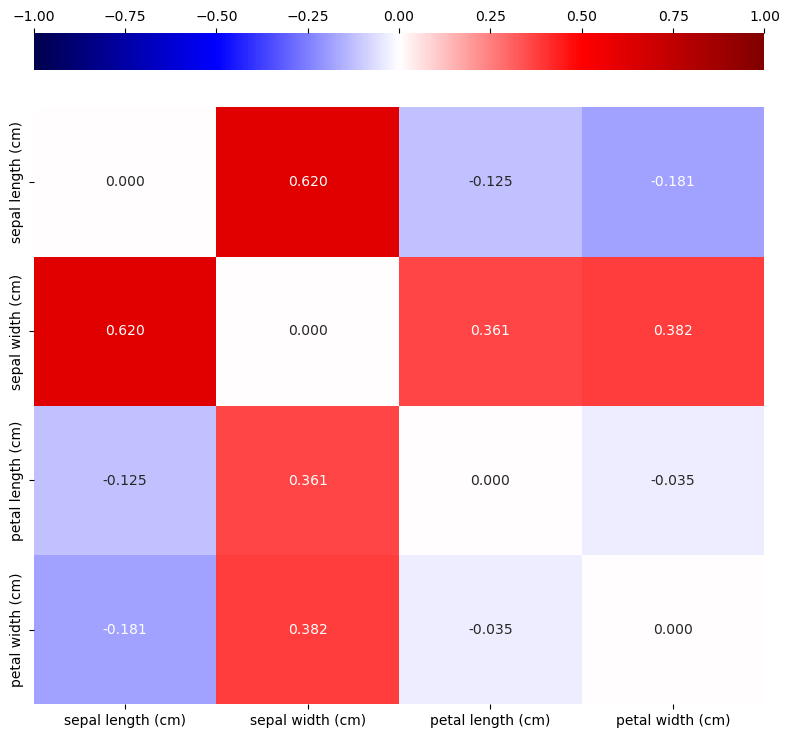

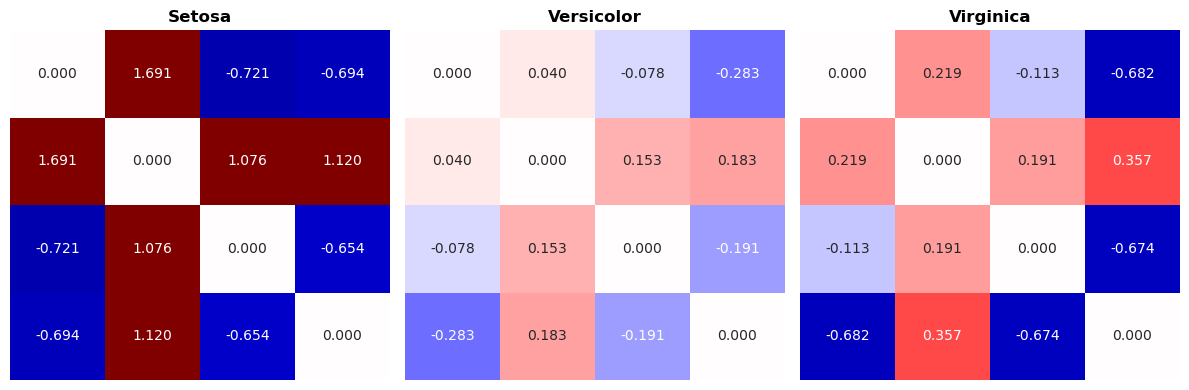

In [19]:
utils.plot_data(real_iris, 'target', vae_df)

Let's train the Conditional GAN.

In [20]:
g_opt = torch.optim.Adam(gen.parameters(), lr = 1e-3)
d_opt = torch.optim.Adam(disc.parameters(), lr = 1e-3)

criterion = nn.BCELoss()

set_seed()
z = torch.randn(150, 4)

In [21]:
for epoch in tqdm(range(501), desc = 'Training Conditional GAN'):
    
    gen_epoch_loss = 0
    disc_epoch_loss = 0
    
    disc.train()
    gen.train()
    
    for data, labels in real_gan_dataloader:
        
        real_data = data
        real_labels = torch.ones(real_data.shape[0], 1)
        
        train_z = torch.randn(real_data.shape[0], 4)
        fake_data = gen(train_z, labels)
        fake_labels = torch.zeros(real_data.shape[0], 1)
        
        disc.zero_grad()
        
        real_loss = criterion(disc(real_data, labels), real_labels)
        fake_loss = criterion(disc(fake_data.detach(), labels), fake_labels)
        d_loss = (real_loss + fake_loss) / 2
        disc_epoch_loss += d_loss.item()
        d_loss.backward()
        
        d_opt.step()
        
        gen.zero_grad()
        
        gen_labels = torch.ones(real_data.shape[0], 1)
        
        g_loss = criterion(disc(fake_data, labels), gen_labels)
        gen_epoch_loss += g_loss.item()
        g_loss.backward()
        
        g_opt.step()
        
    g_epoch_loss = gen_epoch_loss/len(real_gan_dataloader)
    d_epoch_loss = disc_epoch_loss/len(real_gan_dataloader)
    
    if epoch % 50 == 0 or epoch == 500:
        
        print(f'\nEpoch {epoch}/500 | DLoss: {d_epoch_loss:.4f} | GLoss {g_epoch_loss:.4f}')
        with torch.no_grad():
            gen.eval()
            gen_z = gen(z, real_gan_dataloader.dataset.label)
            utils.compare_results(real_gan_dataloader.dataset.data, gen_z)

Training Conditional GAN:   0%|          | 0/501 [00:00<?, ?it/s]


Epoch 0/500 | DLoss: 0.7016 | GLoss 0.6645
MEAN: [-0.082  0.24  -0.297 -0.103]
STD:  [0.966 0.965 0.958 0.972]
MIN:  [-1.85  -2.1   -1.772 -1.433]
MAX:  [2.295 3.239 1.342 1.5  ]
SKEW: [ 0.43   0.306 -1.175  0.509]
KURT: [-0.666  0.813 -2.716 -3.292]

Epoch 50/500 | DLoss: 0.6562 | GLoss 1.0522
MEAN: [-1.407 -0.51   0.004  0.438]
STD:  [-0.123 -0.437 -1.116 -1.861]
MIN:  [-1.242 -1.559  5.8    9.589]
MAX:  [-0.976 -3.57  -0.892 -1.251]
SKEW: [ 0.355 -0.925  0.542  0.82 ]
KURT: [ 0.615 -1.088 -1.219 -1.465]

Epoch 100/500 | DLoss: 0.6819 | GLoss 0.7835
MEAN: [-0.153 -0.344 -0.238  0.051]
STD:  [-0.148  0.36  -0.527  0.049]
MIN:  [ 1.039 -2.095  0.756  0.868]
MAX:  [ 0.325  1.022 -0.121  0.365]
SKEW: [ 0.235 -0.434  0.372 -0.003]
KURT: [ 0.47   0.979  0.076 -0.16 ]

Epoch 150/500 | DLoss: 0.6839 | GLoss 0.7715
MEAN: [ 0.364  0.082 -0.092  0.259]
STD:  [ 0.183  0.106  0.263 -0.247]
MIN:  [-0.164 -1.159 -0.706  0.854]
MAX:  [1.872 1.654 0.584 0.668]
SKEW: [ 0.841 -0.171 -0.478  0.467]
KUR

In [22]:
gan_df = pd.DataFrame(std_scl.inverse_transform(gen_z.detach().numpy()))
gan_df['target'] = y
gan_df['target'] = gan_df['target'].map({i: species[i] for i in range(len(species))})
gan_df.columns = real_iris.columns

In [23]:
utils.describe_data(real_iris, 'target', gan_df)

REAL                      SYNTHETIC             \
                       setosa versicolor virginica    setosa versicolor   
MEAN sepal length (cm)  5.006      5.936     6.588     5.070      5.983   
     sepal width (cm)   3.428      2.770     2.974     3.467      2.997   
     petal length (cm)  1.462      4.260     5.552     1.325      4.439   
     petal width (cm)   0.246      1.326     2.026     0.336      1.157   
STD  sepal length (cm)  0.352      0.516     0.636     0.185      0.410   
     sepal width (cm)   0.379      0.314     0.322     0.263      0.179   
     petal length (cm)  0.174      0.470     0.552     0.153      0.388   
     petal width (cm)   0.105      0.198     0.275     0.118      0.280   
MIN  sepal length (cm)  4.300      4.900     4.900     4.599      4.463   
     sepal width (cm)   2.300      2.000     2.200     3.076      2.783   
     petal length (cm)  1.000      3.000     4.500     1.057      3.310   
     petal width (cm)   0.100      1.000     1.400    -0.014      0.076   
MAX  sepal length (cm)  5.800      7.000     7.900     5.430      6.761   
     sepal width (cm)   4.400      3.400     3.800     4.091      3.377   
     petal length (cm)  1.900      5.100     6.900     1.694      5.395   
     petal width (cm)   0.600      1.800     2.500     0.476      1.548   
SKEW sepal length (cm)  0.116      0.102     0.114    -0.192     -0.812   
     sepal width (cm)   0.040     -0.352     0.355     0.519      0.502   
     petal length (cm)  0.103     -0.588     0.533     0.825      0.285   
     petal width (cm)   1.216     -0.030    -0.126    -1.127     -1.160   
KURT sepal length (cm) -0.346     -0.599    -0.088    -0.165      2.187   
     sepal width (cm)   0.744     -0.448     0.520    -0.619     -1.174   
     petal length (cm)  0.805     -0.074    -0.256    -0.069      0.838   
     petal width (cm)   1.434     -0.488    -0.661     0.586      2.662   
IQR  sepal length (cm)  0.400      0.700     0.675     0.272      0.560   
     sepal width (cm)   0.475      0.475     0.375     0.388      0.323   
     petal length (cm)  0.175      0.600     0.775     0.192      0.498   
     petal width (cm)   0.100      0.300     0.500     0.155      0.398   

                                  
                       virginica  
MEAN sepal length (cm)     6.574  
     sepal width (cm)      3.161  
     petal length (cm)     6.071  
     petal width (cm)      1.508  
STD  sepal length (cm)     0.375  
     sepal width (cm)      0.178  
     petal length (cm)     0.412  
     petal width (cm)      0.225  
MIN  sepal length (cm)     5.193  
     sepal width (cm)      2.714  
     petal length (cm)     4.515  
     petal width (cm)      0.509  
MAX  sepal length (cm)     7.209  
     sepal width (cm)      3.508  
     petal length (cm)     6.619  
     petal width (cm)      1.813  
SKEW sepal length (cm)    -1.181  
     sepal width (cm)     -0.376  
     petal length (cm)    -1.470  
     petal width (cm)     -2.214  
KURT sepal length (cm)     2.833  
     sepal width (cm)      0.187  
     petal length (cm)     3.030  
     petal width (cm)      6.963  
IQR  sepal length (cm)     0.353  
     sepal width (cm)      0.184  
     petal length (cm)     0.434  
     petal width (cm)      0.182

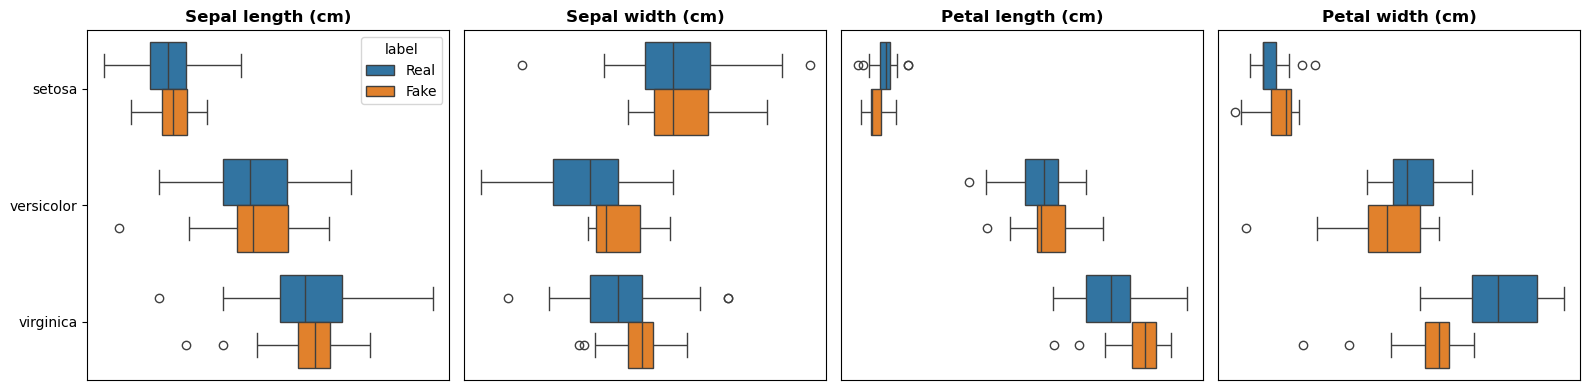

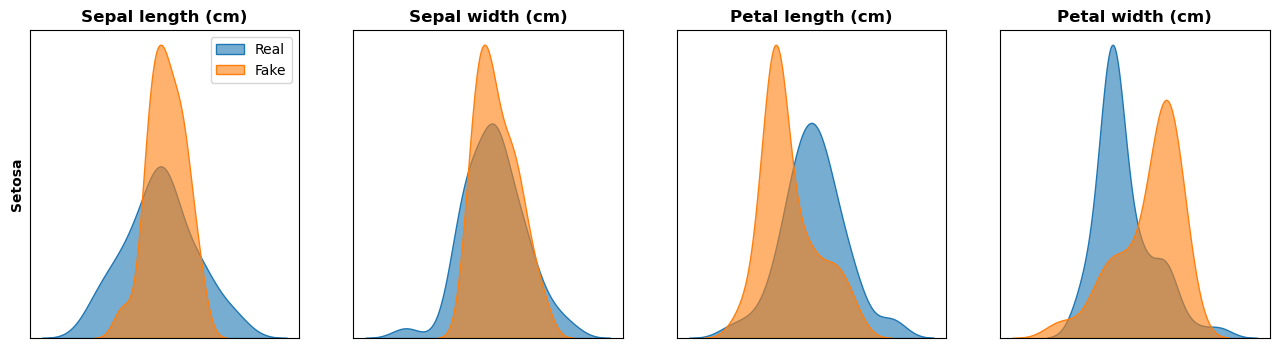

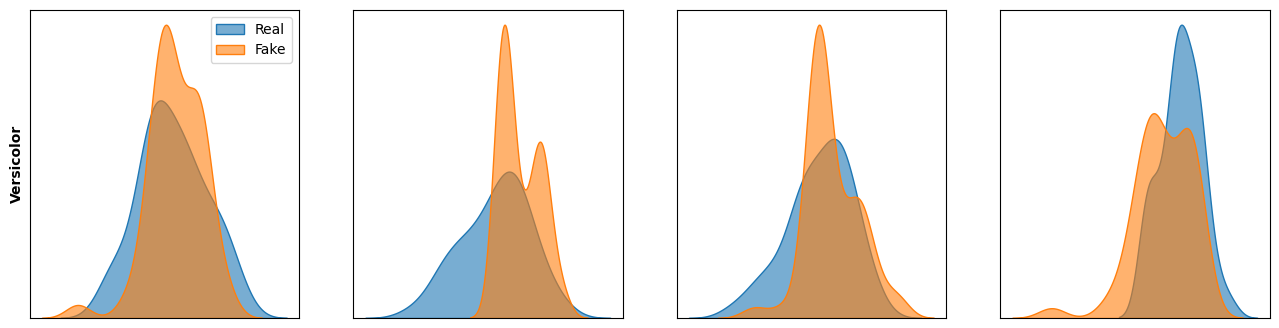

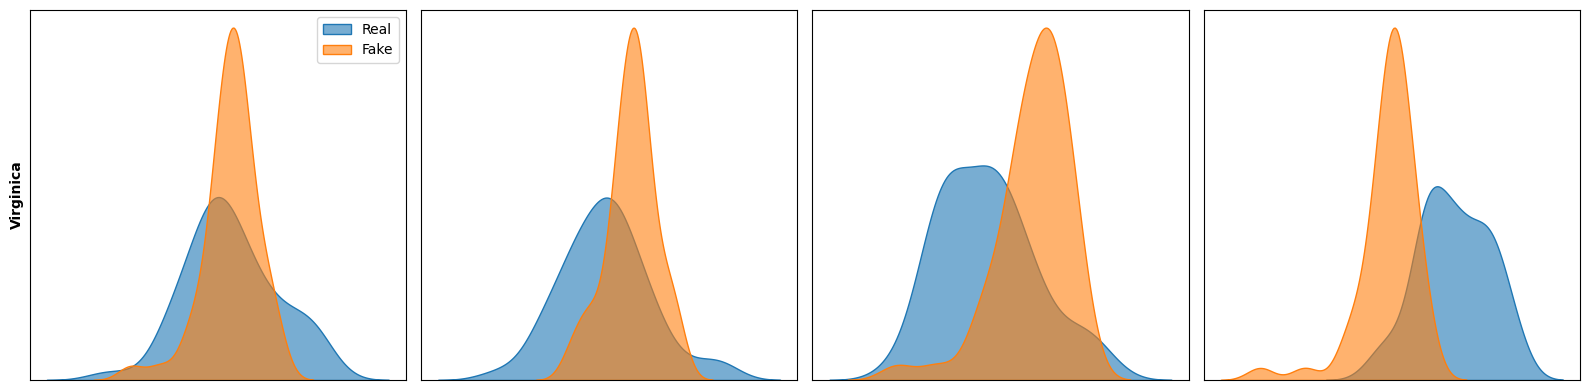

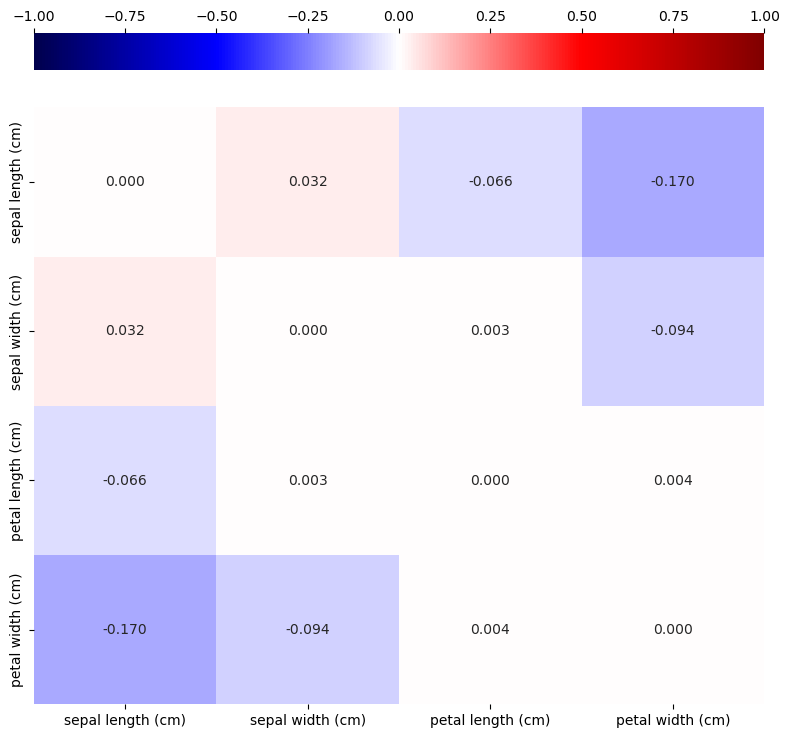

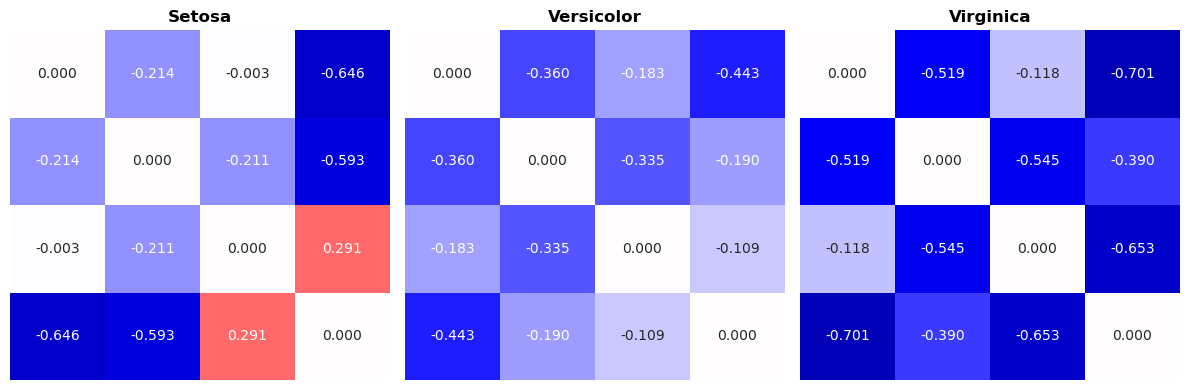

In [24]:
utils.plot_data(real_iris, 'target', gan_df)

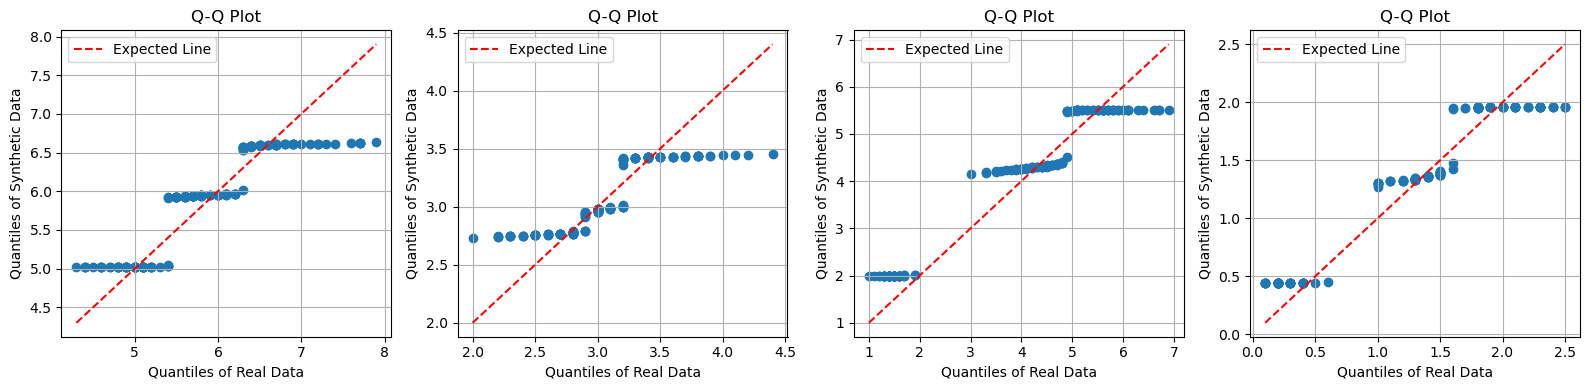

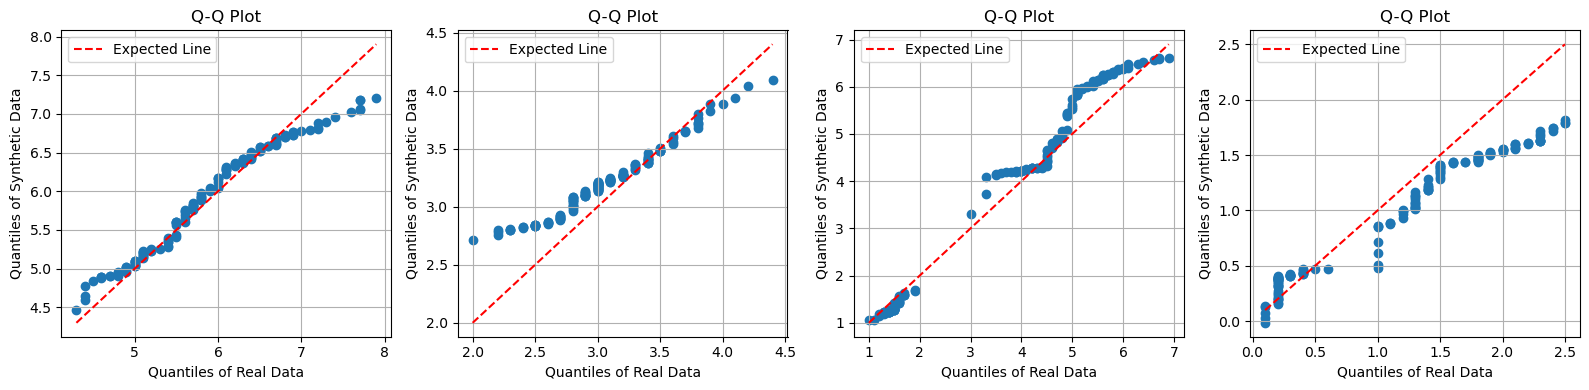

In [25]:
utils.plot_quantiles(real_iris, vae_df)
utils.plot_quantiles(real_iris, gan_df)

The performance of the models is clear: using Q-Q plots we see that the data generated with the simpler GAN show better overlap with the actual data. We will follow this path.

## Conditional Generative Adversarial Network

In this section, we focus on refining the GAN architecture to maximize its performance in generating synthetic data that closely resembles the real dataset. Our aim is to improve the overlap between the distributions of generated and real data while maintaining computational efficiency. The resulting model will form the basis for subsequent evaluations and applications.

The strating point is a model with 861 parameters. We'll build other 2 bigger versions to prove out which is the best.

In [26]:
# Smallest GAN

class Generator1(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        
        self.label_emb = nn.Embedding(num_classes, num_classes)
        
        self.model = nn.Sequential(
            nn.Linear(input_dim + num_classes, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 4),
        )
        
    def forward(self, x, labels):
        label_embeddings = self.label_emb(labels)
        x = torch.cat([x, label_embeddings], dim = 1)
        x = self.model(x)
        return x
    
class Discriminator1(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
            
        self.label_emb = nn.Embedding(num_classes, num_classes)
        
        self.model = nn.Sequential(
            nn.Linear(input_dim + num_classes, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x, labels):
        label_embeddings = self.label_emb(labels)
        x = torch.cat([x, label_embeddings], dim = 1)
        x = self.model(x)
        return x

# Medium GAN

class Generator2(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        
        self.label_emb = nn.Embedding(num_classes, num_classes)
        
        self.model = nn.Sequential(
            nn.Linear(input_dim + num_classes, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 4),
        )
        
    def forward(self, x, labels):
        label_embeddings = self.label_emb(labels)
        x = torch.cat([x, label_embeddings], dim = 1)
        x = self.model(x)
        return x
    
class Discriminator2(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
            
        self.label_emb = nn.Embedding(num_classes, num_classes)
        
        self.model = nn.Sequential(
            nn.Linear(input_dim + num_classes, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x, labels):
        label_embeddings = self.label_emb(labels)
        x = torch.cat([x, label_embeddings], dim = 1)
        x = self.model(x)
        return x

# Big GAN

class Generator3(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        
        self.label_emb = nn.Embedding(num_classes, num_classes)
        
        self.model = nn.Sequential(
            nn.Linear(input_dim + num_classes, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 4),
        )
        
    def forward(self, x, labels):
        label_embeddings = self.label_emb(labels)
        x = torch.cat([x, label_embeddings], dim = 1)
        x = self.model(x)
        return x
    
class Discriminator3(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
            
        self.label_emb = nn.Embedding(num_classes, num_classes)
        
        self.model = nn.Sequential(
            nn.Linear(input_dim + num_classes, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x, labels):
        label_embeddings = self.label_emb(labels)
        x = torch.cat([x, label_embeddings], dim = 1)
        x = self.model(x)
        return x
    
    
small_gan_gen = Generator1(input_dim = 4, num_classes = 3)
small_gan_disc = Discriminator1(input_dim = 4, num_classes = 3)

med_gan_gen = Generator2(input_dim = 4, num_classes = 3)
med_gan_disc = Discriminator2(input_dim = 4, num_classes = 3)

big_gan_gen = Generator3(input_dim = 4, num_classes = 3)
big_gan_disc = Discriminator3(input_dim = 4, num_classes = 3)

small_gan = {'Generator':small_gan_gen, 'Discriminator':small_gan_disc}

med_gan = {'Generator':med_gan_gen, 'Discriminator':med_gan_disc}

big_gan = {'Generator':big_gan_gen, 'Discriminator':big_gan_disc}

In [27]:
for size in [small_gan, med_gan, big_gan]:
    for model in size:
        print(f'{model} parameters: {sum(p.numel() for p in size[model].parameters())/1000}k')

Generator parameters: 0.861k
Discriminator parameters: 0.714k
Generator parameters: 3.197k
Discriminator parameters: 2.858k
Generator parameters: 11.965k
Discriminator parameters: 11.242k


The 3 models have a very different number of parameters. Next step is to set the optimized ones and start training.

In [28]:
small_gan['Generator optimizer'] = torch.optim.Adam(small_gan_gen.parameters(), lr = 1e-3)
small_gan['Discriminator optimizer'] = torch.optim.Adam(small_gan_disc.parameters(), lr = 1e-3)

med_gan['Generator optimizer'] = torch.optim.Adam(med_gan_gen.parameters(), lr = 1e-3)
med_gan['Discriminator optimizer'] = torch.optim.Adam(med_gan_disc.parameters(), lr = 1e-3)

big_gan['Generator optimizer'] = torch.optim.Adam(big_gan_gen.parameters(), lr = 1e-3)
big_gan['Discriminator optimizer'] = torch.optim.Adam(big_gan_disc.parameters(), lr = 1e-3)

criterion = nn.BCELoss()

set_seed()
z = torch.randn(150, 4)

In [29]:
for idx, size in enumerate([small_gan, med_gan, big_gan]):
    
    for epoch in tqdm(range(501), desc = f'Training Conditional GAN {idx + 1}'):
        
        gen = size['Generator']
        disc = size['Discriminator']
        g_opt = size['Generator optimizer']
        d_opt = size['Discriminator optimizer']
        
        gen_epoch_loss = 0
        disc_epoch_loss = 0
    
        disc.train()
        gen.train()
        
        for data, labels in real_gan_dataloader:
            
            real_data = data
            real_labels = torch.ones(real_data.shape[0], 1)
        
            train_z = torch.randn(real_data.shape[0], 4)
            fake_data = gen(train_z, labels)
            fake_labels = torch.zeros(real_data.shape[0], 1)
        
            disc.zero_grad()
            
            real_loss = criterion(disc(real_data, labels), real_labels)
            fake_loss = criterion(disc(fake_data.detach(), labels), fake_labels)
            d_loss = (real_loss + fake_loss) / 2
            disc_epoch_loss += d_loss.item()
            d_loss.backward()
        
            d_opt.step()
        
            gen.zero_grad()
        
            gen_labels = torch.ones(real_data.shape[0], 1)
        
            g_loss = criterion(disc(fake_data, labels), gen_labels)
            gen_epoch_loss += g_loss.item()
            g_loss.backward()
        
            g_opt.step()
            
        g_epoch_loss = gen_epoch_loss/len(real_gan_dataloader)
        d_epoch_loss = disc_epoch_loss/len(real_gan_dataloader)
        
        if epoch % 50 == 0 or epoch == 500:
        
            print(f'\nEpoch {epoch}/500 | DLoss: {d_epoch_loss:.4f} | GLoss {g_epoch_loss:.4f}')
            with torch.no_grad():
                gen.eval()
                gen_z = gen(z, real_gan_dataloader.dataset.label)
                utils.compare_results(real_gan_dataloader.dataset.data, gen_z)

Training Conditional GAN 1:   0%|          | 0/501 [00:00<?, ?it/s]


Epoch 0/500 | DLoss: 0.7026 | GLoss 0.7170
MEAN: [ 0.127  0.005 -0.052  0.255]
STD:  [0.946 0.929 0.95  0.958]
MIN:  [-1.463 -2.23  -1.411 -0.96 ]
MAX:  [2.516 2.769 1.667 1.894]
SKEW: [ 1.791 -0.428  1.312  1.539]
KURT: [-4.448 -1.862 -4.587 -6.005]

Epoch 50/500 | DLoss: 0.6741 | GLoss 0.6164
MEAN: [0.862 0.27  0.909 1.398]
STD:  [0.65  0.894 0.536 0.48 ]
MIN:  [ 0.503 -1.745  1.372  2.242]
MAX:  [2.869 3.205 2.09  2.417]
SKEW: [1.53  1.632 1.024 1.183]
KURT: [-2.197 -2.07  -3.337 -3.321]

Epoch 100/500 | DLoss: 0.7720 | GLoss 0.7664
MEAN: [ 0.696  1.498 -0.953 -0.787]
STD:  [-0.405 -0.445 -0.497 -0.188]
MIN:  [ 3.498  2.812  0.889 -0.029]
MAX:  [ 1.296  1.934 -2.087 -1.811]
SKEW: [ 1.111  0.396 -0.057 -0.141]
KURT: [-0.395  1.166 -0.378 -0.2  ]

Epoch 150/500 | DLoss: 0.6407 | GLoss 0.9067
MEAN: [-0.369 -0.172  0.436 -0.558]
STD:  [-0.17  -0.059 -0.006 -0.164]
MIN:  [-0.339 -1.352  0.738 -0.365]
MAX:  [ 0.133  0.964  1.239 -1.96 ]
SKEW: [ 0.72  -0.438  0.509 -0.471]
KURT: [ 0.735  

Training Conditional GAN 2:   0%|          | 0/501 [00:00<?, ?it/s]


Epoch 0/500 | DLoss: 0.6818 | GLoss 0.6496
MEAN: [0.216 0.127 0.211 0.029]
STD:  [0.977 0.982 0.98  0.985]
MIN:  [-1.597 -2.261 -1.279 -1.334]
MAX:  [2.583 3.163 1.939 1.709]
SKEW: [-0.746 -0.166  0.089  1.171]
KURT: [-3.986  0.318 -1.581 -4.195]

Epoch 50/500 | DLoss: 0.6312 | GLoss 1.1650
MEAN: [-0.418 -2.814  0.805 -0.699]
STD:  [-0.232  0.228 -0.318 -0.337]
MIN:  [-0.115 -4.067  2.254  0.367]
MAX:  [ 0.761 -2.683  1.456 -0.36 ]
SKEW: [ 0.94  -0.443  0.483  0.537]
KURT: [ 0.887 -0.637 -0.14   0.099]

Epoch 100/500 | DLoss: 0.6500 | GLoss 0.7206
MEAN: [-0.636  0.036  0.045  0.193]
STD:  [0.057 0.915 0.373 0.355]
MIN:  [-1.21  -2.244 -0.478  0.096]
MAX:  [0.156 2.896 0.751 1.115]
SKEW: [ 0.271 -0.071 -0.102  0.432]
KURT: [0.875 1.192 0.057 0.012]

Epoch 150/500 | DLoss: 0.5859 | GLoss 0.8759
MEAN: [-0.883  0.36  -0.813 -0.457]
STD:  [ 0.235  0.494 -0.272  0.41 ]
MIN:  [-1.811 -1.456 -0.562 -1.054]
MAX:  [ 0.264  2.647 -0.876  0.395]
SKEW: [ 0.262 -0.225  0.064  0.18 ]
KURT: [0.908 1.

Training Conditional GAN 3:   0%|          | 0/501 [00:00<?, ?it/s]


Epoch 0/500 | DLoss: 0.6892 | GLoss 0.6937
MEAN: [-0.126  0.146 -0.174  0.086]
STD:  [0.988 0.993 0.99  0.996]
MIN:  [-1.967 -2.264 -1.718 -1.335]
MAX:  [2.331 3.208 1.563 1.782]
SKEW: [ 0.494 -0.046 -1.098  0.267]
KURT: [ 0.437  0.354 -2.488 -1.337]

Epoch 50/500 | DLoss: 0.5211 | GLoss 1.8073
MEAN: [ 3.084 -0.748  1.584  2.908]
STD:  [-0.972  0.476 -0.127 -0.732]
MIN:  [ 6.175 -2.432  2.857  5.829]
MAX:  [2.781 1.012 1.763 2.157]
SKEW: [ 0.736 -0.115  0.154  0.325]
KURT: [ 0.313  1.042 -0.518 -0.46 ]

Epoch 100/500 | DLoss: 0.3748 | GLoss 2.2745
MEAN: [-0.519  1.376 -0.378 -0.34 ]
STD:  [0.726 0.383 0.943 0.789]
MIN:  [-2.017  0.308 -1.858 -1.506]
MAX:  [1.355 3.653 1.289 0.88 ]
SKEW: [-0.031  0.687 -0.499 -0.526]
KURT: [ 0.567  1.344 -0.124 -0.238]

Epoch 150/500 | DLoss: 1.4266 | GLoss 0.7976
MEAN: [ 1.382  4.141  3.149 -0.939]
STD:  [ 0.388 -0.877 -0.442  0.497]
MIN:  [ 1.852  8.763  6.859 -1.645]
MAX:  [ 2.79   4.363  2.398 -1.202]
SKEW: [ 1.651  1.728  0.769 -1.784]
KURT: [-3.4

Great! Now we can compare the results to choose the best architecture.

In [30]:
gen1_z = small_gan['Generator'](z, real_gan_dataloader.dataset.label)
gen2_z = med_gan['Generator'](z, real_gan_dataloader.dataset.label)
gen3_z = big_gan['Generator'](z, real_gan_dataloader.dataset.label)

In [31]:
gan1_df = pd.DataFrame(std_scl.inverse_transform(gen1_z.detach().numpy()))
gan1_df['target'] = y
gan1_df['target'] = gan1_df['target'].map({i: species[i] for i in range(len(species))})
gan1_df.columns = real_iris.columns

gan2_df = pd.DataFrame(std_scl.inverse_transform(gen2_z.detach().numpy()))
gan2_df['target'] = y
gan2_df['target'] = gan2_df['target'].map({i: species[i] for i in range(len(species))})
gan2_df.columns = real_iris.columns

gan3_df = pd.DataFrame(std_scl.inverse_transform(gen3_z.detach().numpy()))
gan3_df['target'] = y
gan3_df['target'] = gan3_df['target'].map({i: species[i] for i in range(len(species))})
gan3_df.columns = real_iris.columns

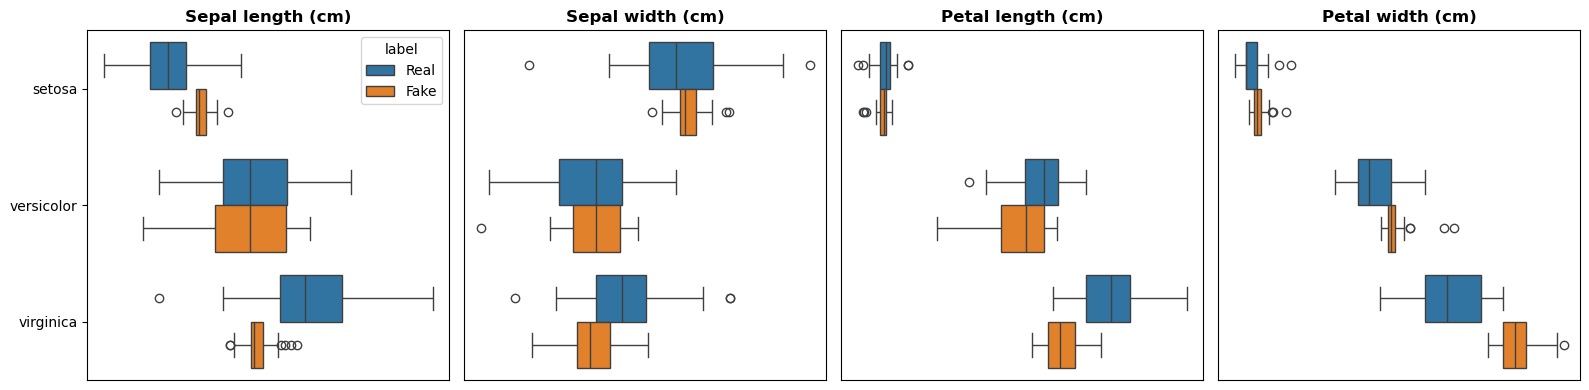

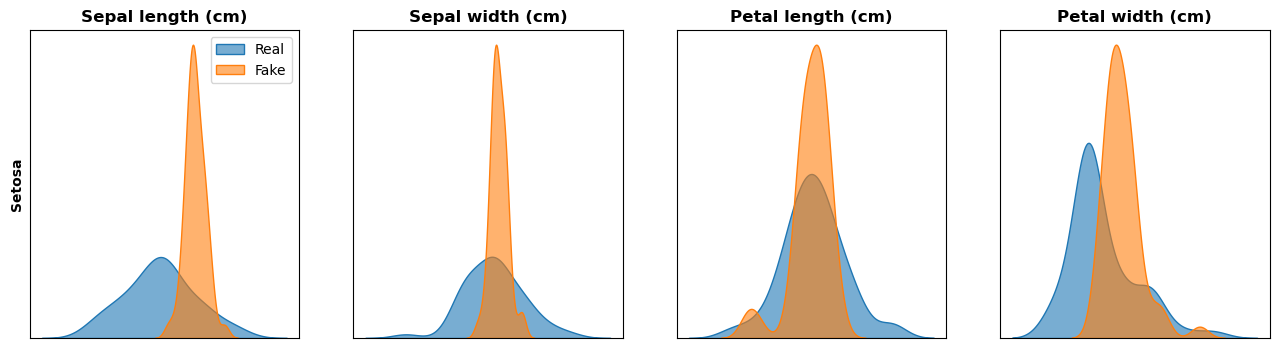

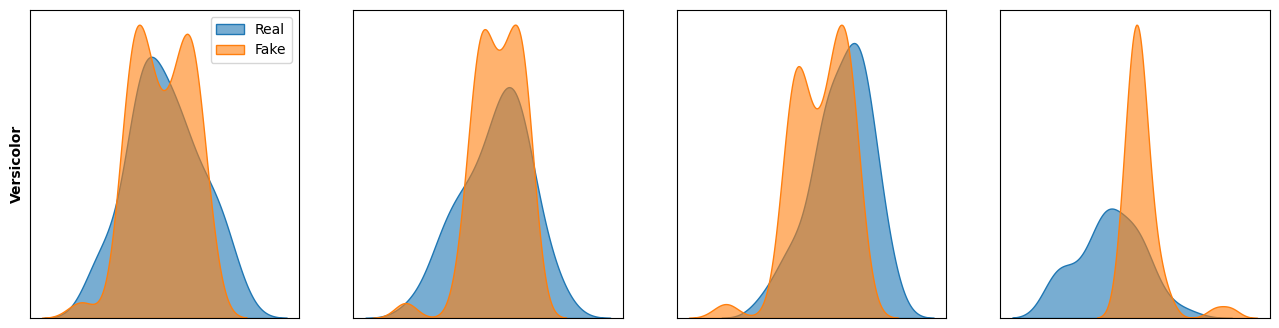

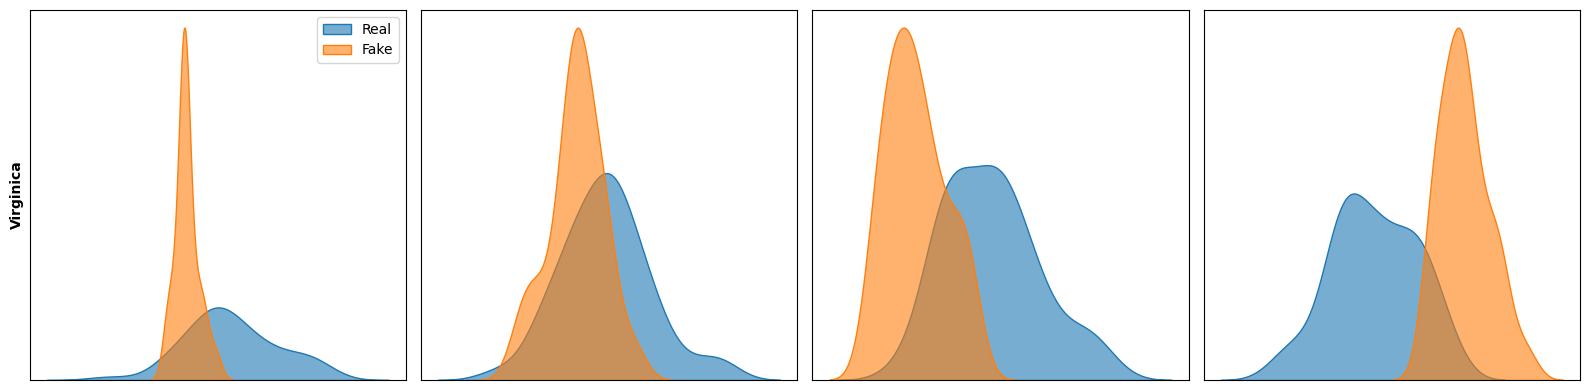

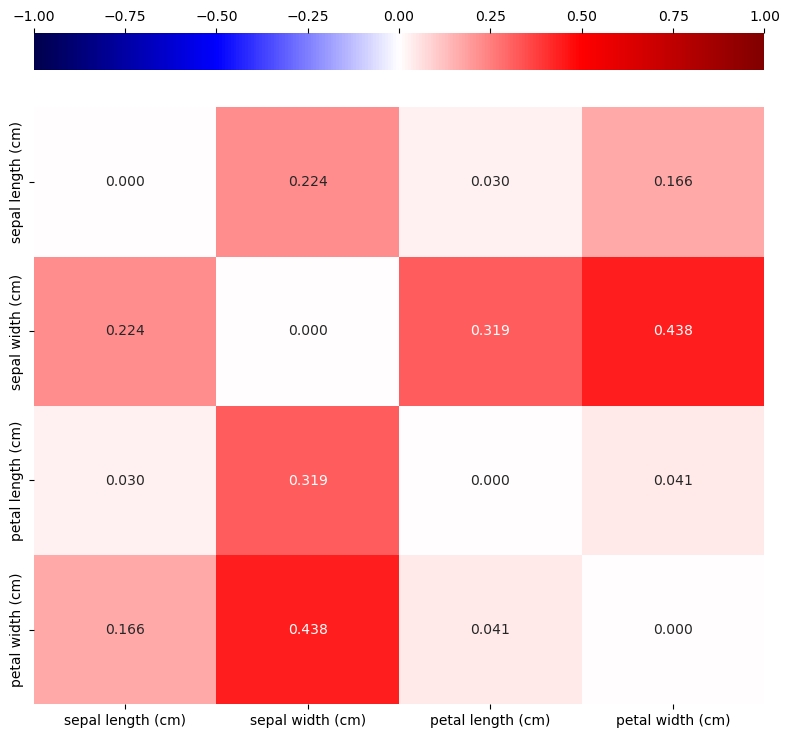

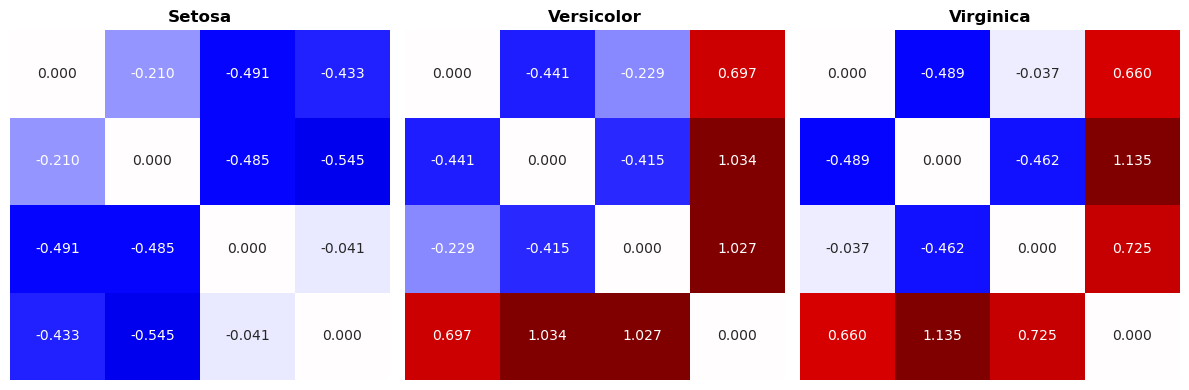

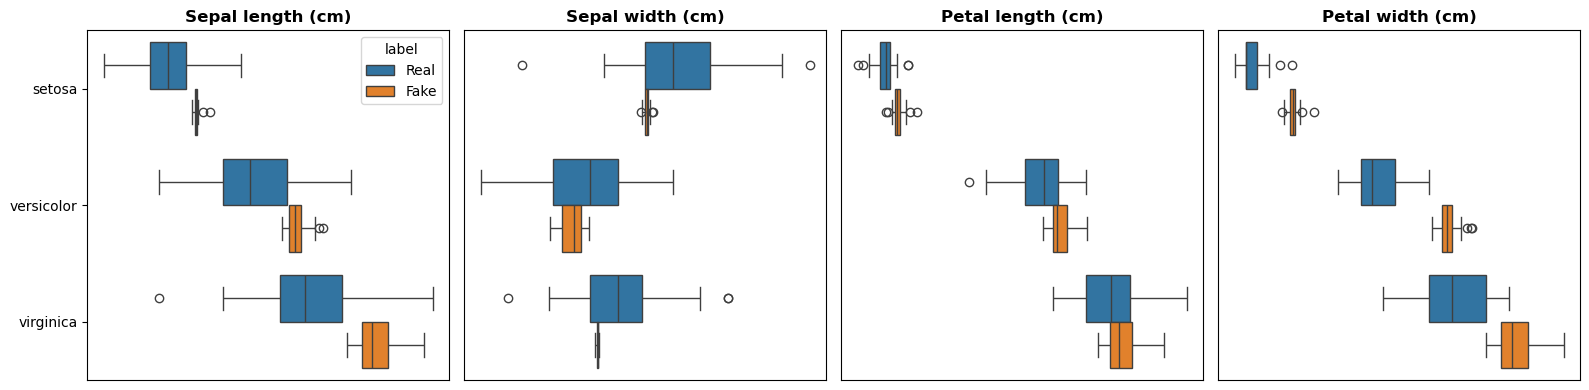

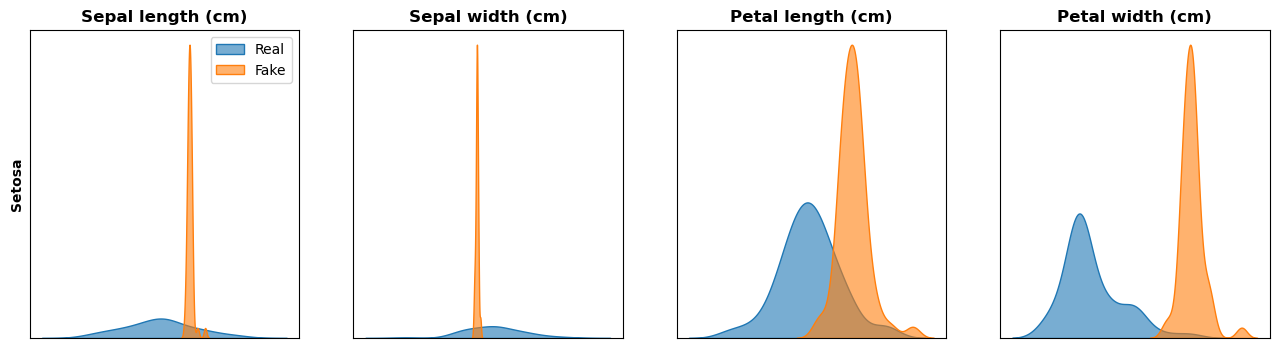

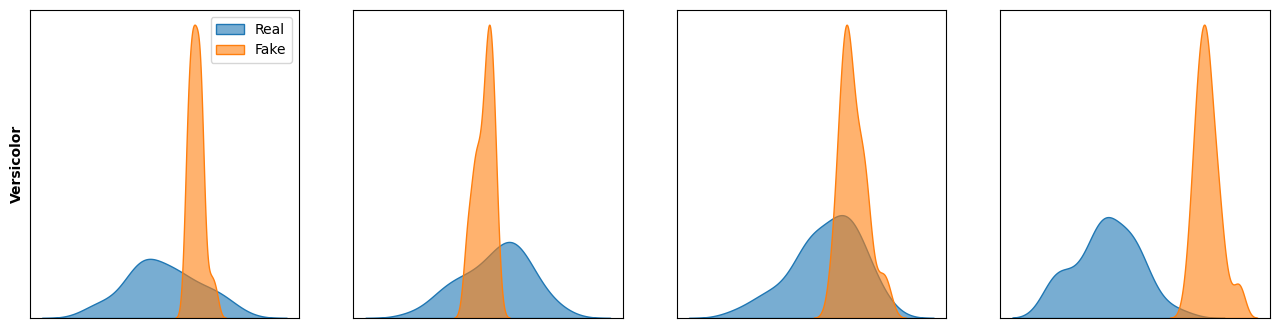

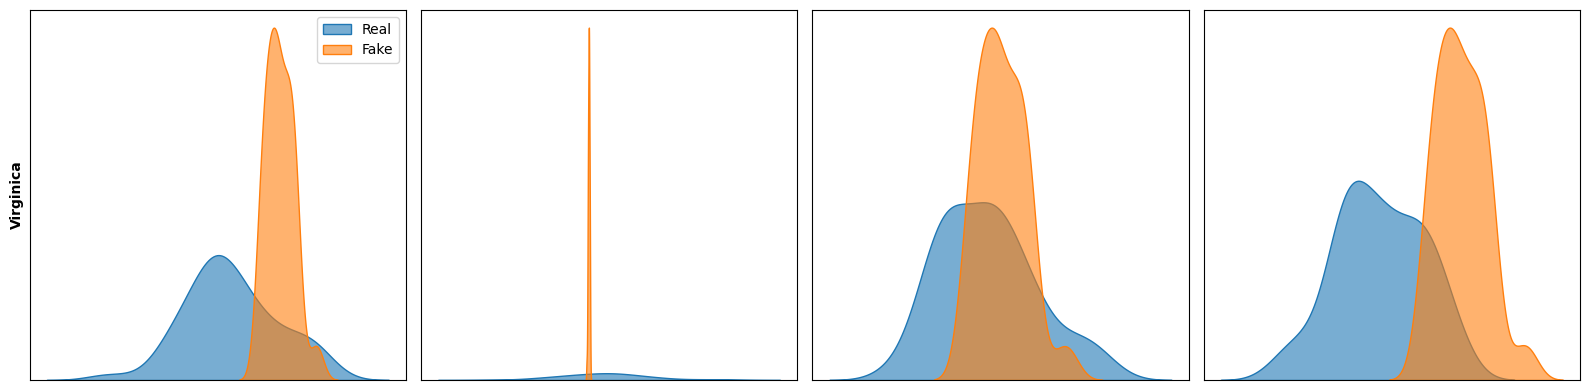

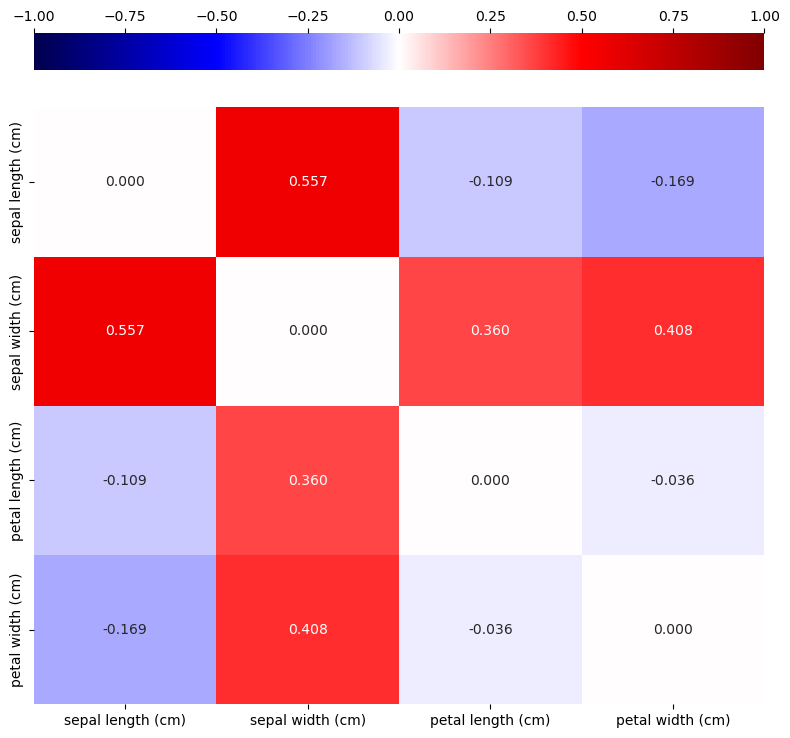

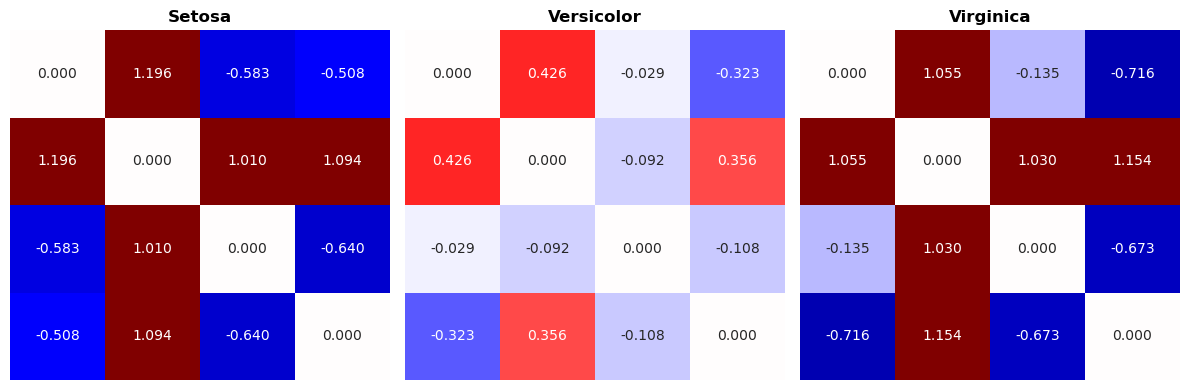

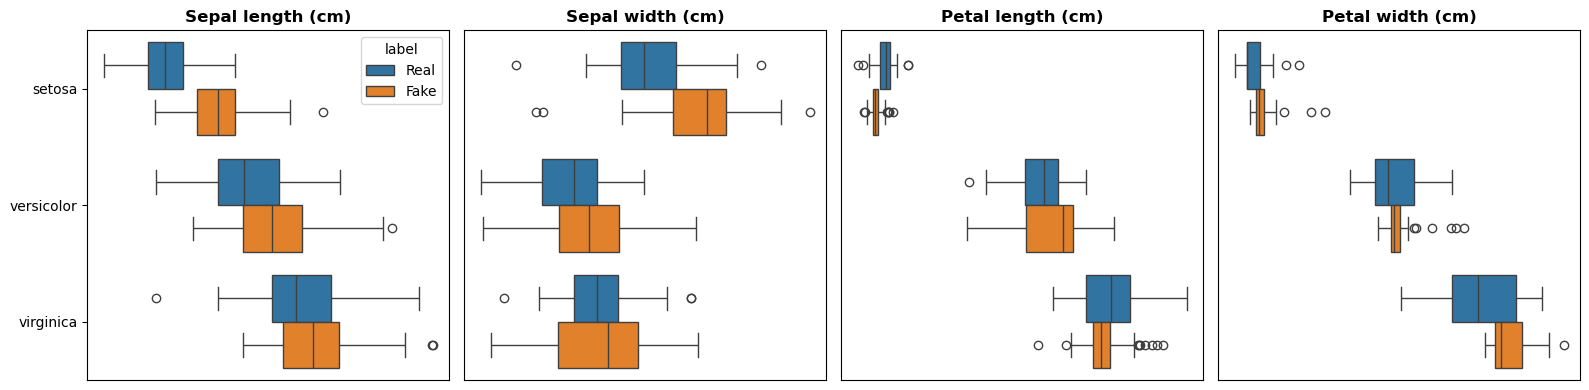

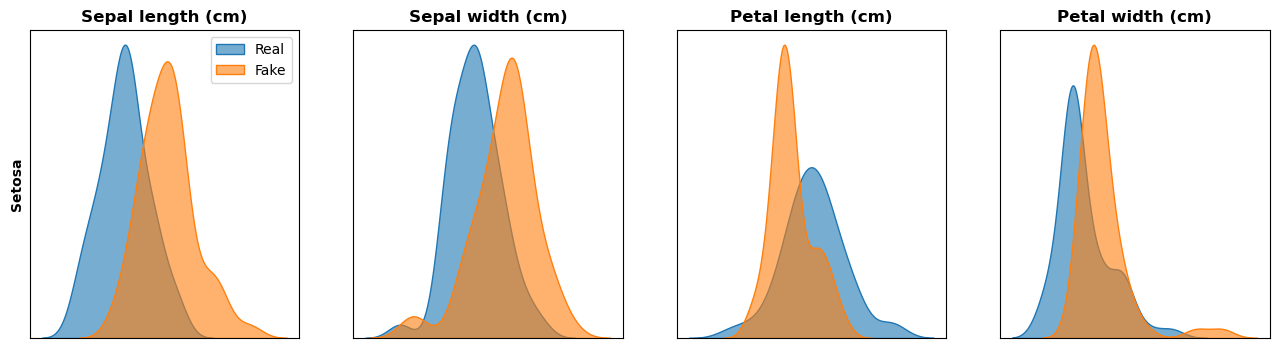

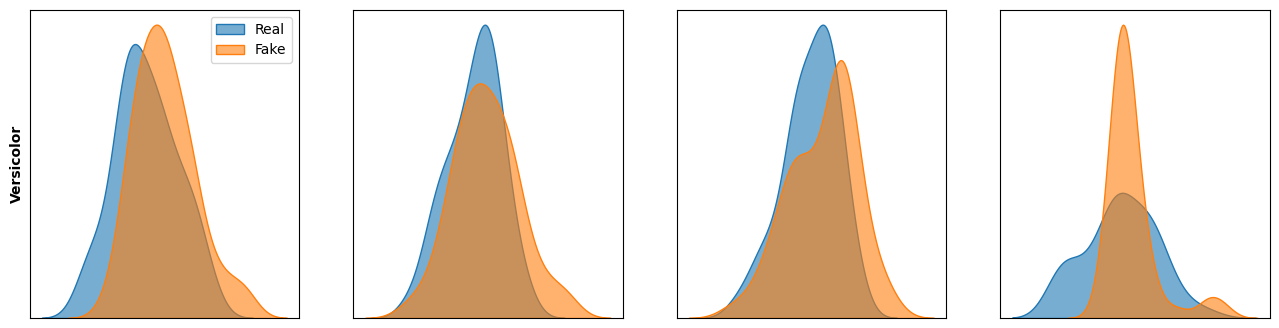

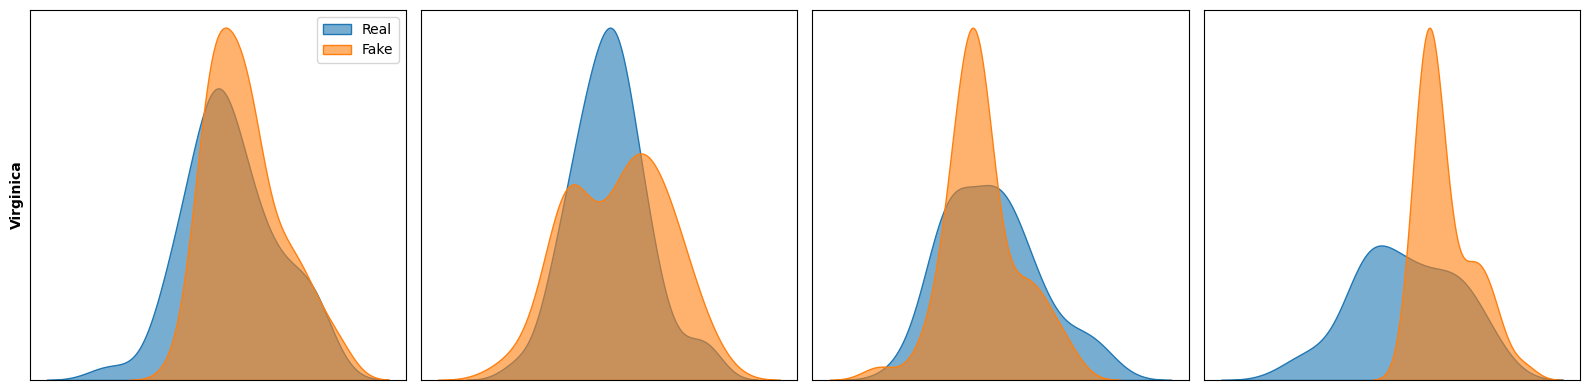

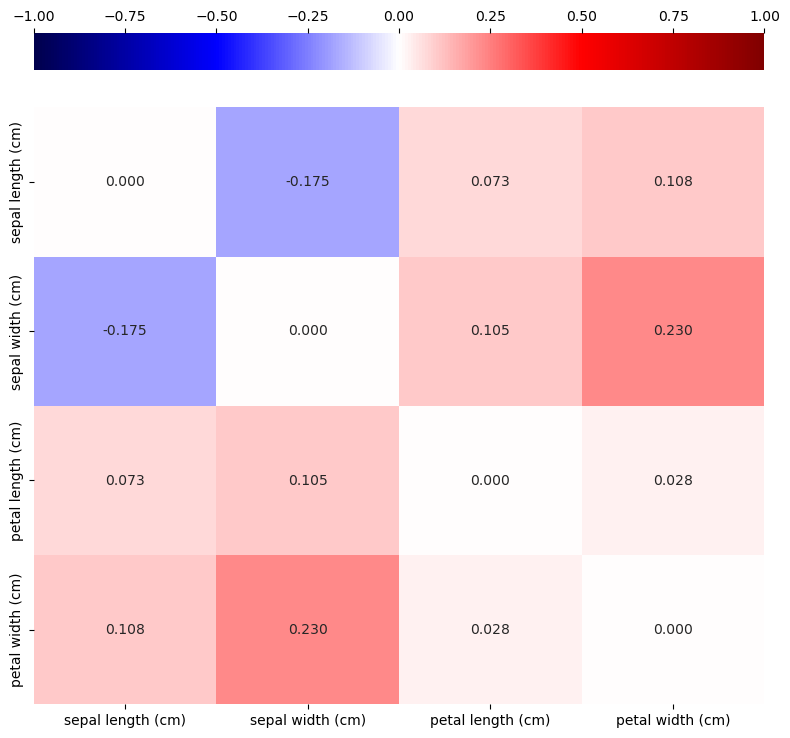

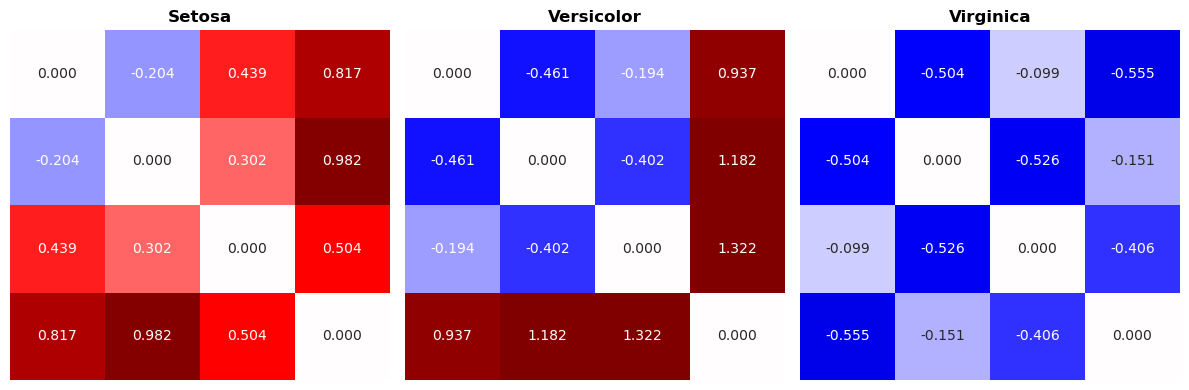

In [32]:
utils.plot_data(real_iris, 'target', gan1_df)
utils.plot_data(real_iris, 'target', gan2_df)
utils.plot_data(real_iris, 'target', gan3_df)

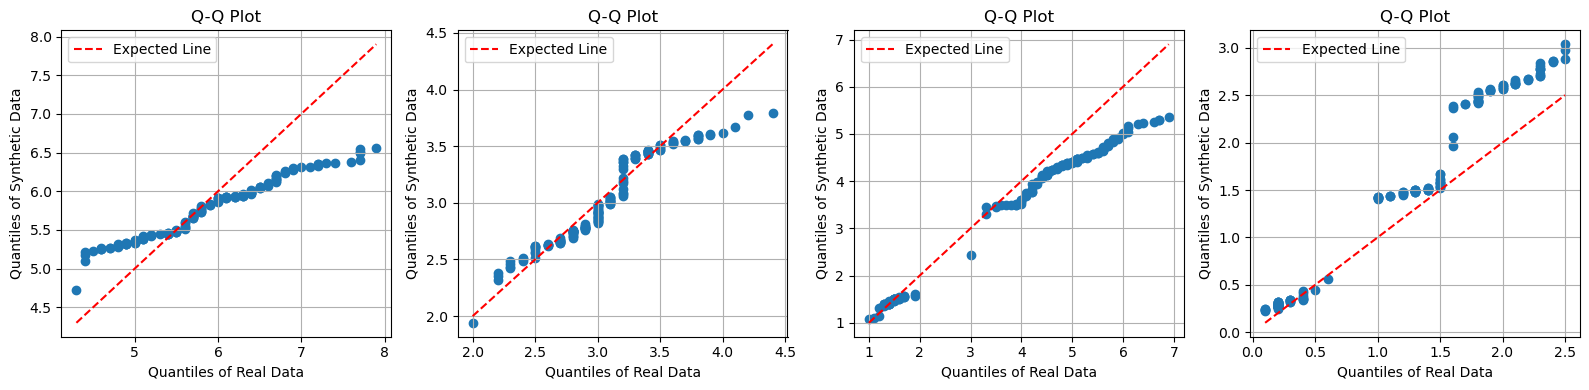

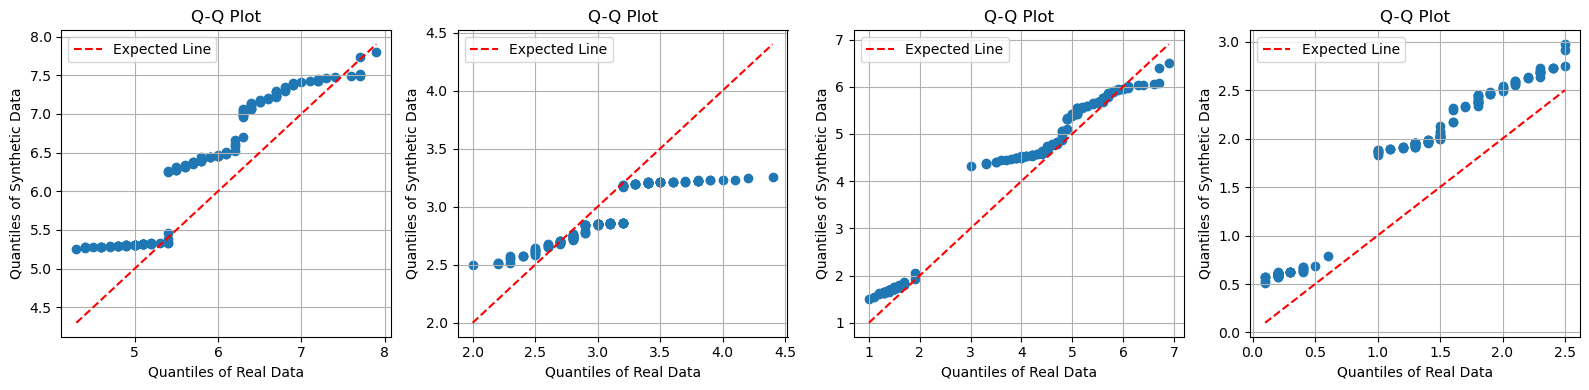

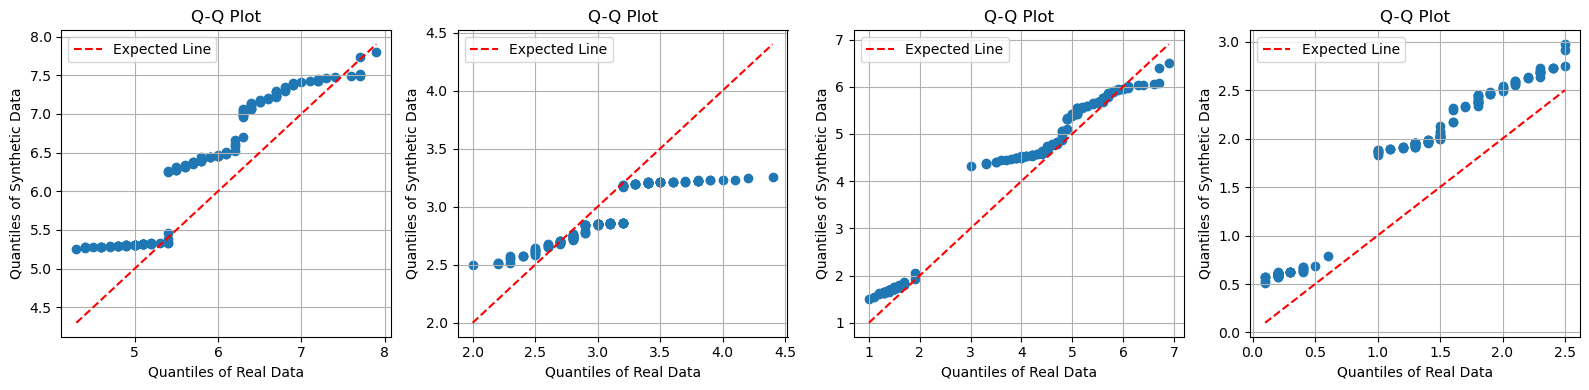

In [33]:
utils.plot_quantiles(real_iris, gan1_df)
utils.plot_quantiles(real_iris, gan2_df)
utils.plot_quantiles(real_iris, gan2_df)

Overall, for the same noise vector size, it is the smaller model that shows the best performance: in fact it produces the smallest differences between the observed and recreated correlations, and in the Q-Q plots we can see how the two distributions tend to overlap more than the other two models. 

We will continue with the fine tuning of this architecture. But first we will look for the best size of the noise vector.

In [37]:
np.round(real_iris.select_dtypes('number').corr() - gan1_df.select_dtypes('number').corr(), 3).sum().sum()

2.436

In [38]:
np.round(real_iris.select_dtypes('number').corr() - gan2_df.select_dtypes('number').corr(), 3).sum().sum()

2.0220000000000002

In [39]:
np.round(real_iris.select_dtypes('number').corr() - gan3_df.select_dtypes('number').corr(), 3).sum().sum()

0.738